# Paper figures 
## A general polarimetric model for transiting and non-transiting ringed exoplanets

This notebook uses `Pryngles` to calculate the results and generate the figures of the paper:

> A general polarimetric model for transiting and non-transiting ringed exoplanets, Allard. K. Veenstra, Jorge I. Zuluaga, Jaime A. Alvarado-Montes, Mario Sucerquia and Daphne M. Stam (submitted).

It is designed for reproducibility purposes, but also for showing a fully-fledged example of how the `Legacy` interface of `Pryngles` can be used for a real scientific application.

## Preliminary

### Required packages

You will need to install the following packages:

- Pryngles (version >= 0.9.5)
- OpenCV.

If you are in a Linux environment just run:

In [1]:
!pip install -qU opencv-python pryngles


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Pryngles pakages and modules:

In [2]:
%load_ext autoreload
%autoreload 2
import pryngles as pr
from pryngles import Consts

# Aliases
prymark = pr.Plot.pryngles_mark # Pryngles water mark for plots

# Extension 
extension = 'cpixx'
print(f"Pryngles version: {pr.version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pryngles version: 0.9.10


Import dependencies

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import least_squares
import joblib
import math
import time
import re
import sys
import pandas as pd
import cv2 as cv
import pickle
from copy import deepcopy
from tqdm import tqdm
from collections import OrderedDict

Configuration of imported packages:

In [4]:
plt.rcParams.update({'font.size': 20})

# If Jupyter
mpl.rcParams['text.usetex'] = True
%matplotlib nbagg

# If Google Colab, uncomment
"""
mpl.rcParams['text.usetex'] = True
%matplotlib inline
#""";

number_processors = joblib.cpu_count()-2 if joblib.cpu_count()>2 else joblib.cpu_count()
print(f"Number of available processors: {number_processors}")

# Measuring the total execution time
TINI = time.time()

Number of available processors: 6


### Configuration of the environment

In order to run this scripts is better to have directories for the temporary files and figure files. If you are in Linux use the following cell, otherwise create manually the directories:

In [5]:
!mkdir -p tmp/ figures/final/

You may change the directory names:

In [6]:
tmp_dir = "tmp/"
fig_dir = "figures/"
fig_final_dir = "figures/final/"

### Get required data

`Pryngles` has a public **Google Drive repository** with data required for scattering calculations, mainly, files of the fourier coefficients for computing reflection and transmission on the planetary atmosphere and rings. The repo is publicly available at https://bit.ly/pryngles-data and you may download manually the data files. 

However, we have provided with the latest version of `Pryngles` with a method to retrieve the data. The method can be used to retrieve the list of all files:

In [7]:
allfiles=pr.Misc.retrieve_data([],path=tmp_dir,overwrite=False,quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.


Or it can be used to retrieve specific files:

In [8]:
files=["fou_ring_0_4_0_8.dat","fou_bmsca60.0_asurf1.0.dat"]
pr.Misc.retrieve_data(files,path=tmp_dir,overwrite=False,quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_0_4_0_8.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_bmsca60.0_asurf1.0.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca60.0_asurf1.0.dat']


['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca60.0_asurf1.0.dat']

### Useful routines

The code in this notebook require a few special routines, most of them related to `matplotlib` styling. It is better to define these routines at the very beginning to avoid an excess of repeated code.

In [9]:
def setup_plot(ax,maticksizex,xlim0,xlim1,maticksizey,ylim0,ylim1,notext=False):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(maticksizex))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(maticksizey))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if notext:
        ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
    ax.tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2g"))
    ax.set_xlim([xlim0,xlim1])
    ax.set_ylim([ylim0,ylim1])
    ax.patch.set_alpha(0.0)
    
def add_subplot_axes(ax,rect,facecolor='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def save_figure(fig, fig_name, fig_dir='/tmp', 
                dpi=100, formats=['png'],quiet=False,
                **options):
    """Save a figure to different image formats
    
    Available formats: png, svg, eps
    """
    for form in formats:
        fig_file = fig_dir + fig_name + '.' + form
        if not quiet:
            print(f"Saving {fig_file}...")
        fig.savefig(fig_file,format=form,dpi=dpi,bbox_inches='tight',**options)
        
def save_planet_views(RP,suffix=None,quiet=False):
    if not suffix:
        suffix=f"oi_{RP.iorb}-rl_{RP.alphar}-ri_{RP.gamma}"
    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
    for rf in "ecl","obs","star":
        fig=eval(f"{rf}_fig")
        save_figure(fig,f"config-{suffix}-{rf}",
                    fig_dir=fig_dir, dpi=300, formats=["png"], quiet=quiet)
        
def convert_normal_vectors(i,phi):
    """This routine convert the inclination parameters normally 
    reported in literature to Pryngles input angles (gamma and lambr)
    
    Parameters:
        i: float [degrees]:
            Inclination with respect to the plane of the sky, 90 is edge-on, 0 is face-on.
        phi: float [degrees]: 
            Roll-angle in the plane of the sky.
            
    Return:
        gamma: float [degrees]:
            Inclination with respect to the plane of the sky, 90 is edge-on, 0 is face-on.
        lambr: float [degrees]:
            Roll angle.
    """
    def func(x,i,phi):
        return [np.sin(x[1])*np.cos(x[0]) - np.sin(phi)*np.sin(i),
                np.sin(x[0]) - np.cos(phi)*np.sin(i),
                np.cos(x[1])*np.cos(x[0]) - np.cos(i)]
    fit = least_squares(func, np.array([60*Consts.deg,40*Consts.deg]), 
                        args=(i*Consts.deg,phi*Consts.deg))
    gamma, lambr = fit.x
    return gamma*Consts.rad,lambr*Consts.rad,fit.fun

def notqdm(x):return x

## The basics step-by-step

The paper aims at studying the light-curves of a model planet and an actual planet, under a diverse set of geometric, orbital and physical conditions. 

Here we list the key variables on which the polarimetric light-curve depends. We use the same notation as in the paper to represent the variables. 

Usually modified variables:

- `iorb`, $i$: Orbital sky inclination (w.r.t. the plane of the sky). Inclination of 90 degrees mean a edge-on orbit.
- `gamma`, $\gamma$: Ring sky inclination. Inclination of 90 degrees mean a edge-on ring.
- `lambr`, $\lambda_{\rm r}$: Ring sky roll angle. If $\gamma\neq 0$ then when $\lambda_{\rm r}=90^\circ$ the ring will be edge-on.
- `omegar`, $\varpi_{\rm r}$: Single scattering albedo of the ring particles.
- `tau_ring`, $b_{\rm r}$: Optical thickness of the ring.
- `omegap`, $\varpi_{\rm p}$: Albedo of the planet surface.
- `bp`, $b_{\rm p}$: Optical thickness of planet atmosphere.
- `ring_re`, $r_{\rm in}$: Outer ring radius measured in planetary radii.

Derived parameters (they depend on the value of the previous variables):

- `ir`: Ring ecliptic inclination, when `ir` = 0, the ring is on the orbit plane.
- `beta_obs`: Ecliptic latitude of the observer.
- `lamb_obs`: Ecliptic longitude of the observer.
- `lamb_star`: Initial ecliptic longitude of the star.

Other physical parameters:

- `ring_ri`, $r_{\rm in}$: Inner ring radius measured in planetary radii.
- `ring_re`, $r_{\rm out}$: Outer ring radius measured in planetary radii.
- `Rs`, $R_\star$: Radius of the star in meters.
- `Rp`, $R_p$: Radius of the planet in meters.
- `a`, $a$: planet orbit semimajor axis in au.
- `e`, $e$: planet orbit eccentricity.

Let's a choose a set of values for these parameters:

In [10]:
# Geometrical factors
iorb = 20.0 # Orbital inclination, 90 degrees is edge-on orbit
gamma = 60.0 # Ring inclination, 90 degrees is edge-on orbit
lambr = 30.0 # Ring roll angle, if gamma > 0, when lambr = 90 the ring is edge-on

# Optical parameters
tau_ring = 1.0 # Optical thickness of the ring
omegar = 0.8 # Single scattering albedo of ring particles
bp = 10.0 # Optical thickness of planet atmosphere
omegap = 0.5 # Albedo of planet surface

# Planet and ring size
Rs = Consts.rsun # Stellar radius in m
Rp = Consts.rsaturn # Planet radius in m
ring_ri = 1.2
ring_re = 2.25

# Orbital properties
a = 1.0 # au
e = 0.0 

# Number of spangles
resolution = 10 # Resolution factor. For production purposes use resolution = 10
Np = 1000*resolution # Number of spangles in planet
Nr = 1000*resolution # Number of spangles in ring
Ns = 30
Nb = 0

# Orientation w.r.t. ecliptic
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,lambr)

# Fourier coefficients file
fou_file_planet = f'fou_bmsca{bp:.1f}_asurf{omegap:.1f}.dat'
fou_file_ring = f'fou_ring_{str(tau_ring).replace(".","_")}_{str(omegar).replace(".","_")}.dat'

# Check if coefficients file are available in data repo 
pr.Misc.retrieve_data([fou_file_planet,fou_file_ring],path=tmp_dir,overwrite=False,quiet=False)
print(f"Fourier coefficients files required: {[fou_file_planet,fou_file_ring]}")

# Report conditions
print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg


Using this parameters we can *instantiate* a system composed by a star, a planet and its ring. For this paper we use the `legacy` or `RingedPlanet` interface of `Pryngles` (see the documentation for details):

In [11]:
sys = pr.System(units=['au','msun','yr2pi'])

S=sys.add(
    kind="Star",
    physics=dict(radius=Rs/sys.ul),
    optics=dict(limb_coeffs=[0.65])
)

P=sys.add(
    kind="Planet", primary=S,
    radius=Rp/sys.ul,
    orbit=dict(a=a, e=e),
    physics=dict(radius=Rp/sys.ul),
    optics=dict(nspangles=Np)
)

R=sys.add(
    kind="Ring", primary=P,
    physics=dict(fi=ring_ri, fe=ring_re, i=ir, taur=tau_ring),
    optics=dict(nspangles=Nr)
)

RP=sys.ensamble_system(extension=extension,
                       fname_planet=tmp_dir + fou_file_planet,
                       fname_ring=tmp_dir + fou_file_ring)

Some additional properties must be modified after the ensambling is performed:

In [12]:
# Update additional properties
RP.behavior["interp_method_ring"] = 'spline'
RP.reference_plane = 'Detector'
RP.iorb = iorb
RP.gamma = gamma
RP.alphar = lambr
RP.Ns = Ns
RP.Np = Np
RP.Nr = Nr
RP.Nb = Nb
RP.updatePhysicalProperties(dict(taur = tau_ring))
RP.updateProperties()

For the tests below we need to set the position of the observer and the star:

In [13]:
# Set observer and stellar position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_star)
RP.updateSpangles()

Let's preview the *visual configuration* of the planet, as seen from the observer point of view:

<IPython.core.display.Javascript object>


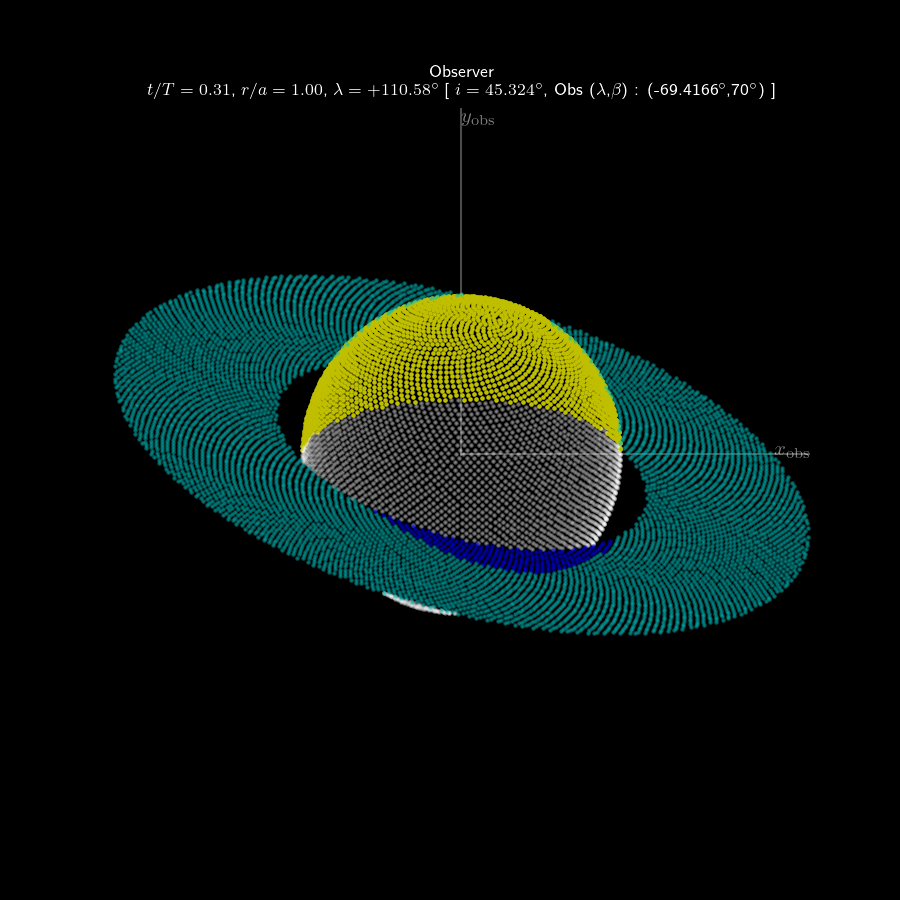

In [14]:
ecl,obs,star=RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=True,axis=True)
obs

Visual configurations will be key for several figures hereafter, so, it is very convenient to save them for future uses. For this purpose we can use one of the useful routine defined at the beginning:

In [15]:
save_planet_views(RP,quiet=False)

Saving figures/config-oi_20.0-rl_30.0-ri_60.0-ecl.png...
Saving figures/config-oi_20.0-rl_30.0-ri_60.0-obs.png...
Saving figures/config-oi_20.0-rl_30.0-ri_60.0-star.png...


Probably the most important task in this Notebook is the calculation of the polarimetric light-curve. For this purpose we will use the method `compute_polarimetric_curve` from `Pryngles`.  This is a general procedure that calculate only the reflected/transmitted light for a range of ecliptic longitudes. The method returns the `LC` matrix with the following columns:

- Column 0: lambda [degrees]
- Column 1: Total flux, Stot
- Column 2: Polarized flux, Pflux
- Column 3: Total degree of polarization, Ptot
- Column 4: Phase angle [degrees], alpha
- Columns 5,6,7 (5:8): Total stokes vector (F,Q,U), Stot[]
- Columns 8,9,10 (8:11): Planet stokes vector (F,Q,U), Stotp[]
- Columns 11,12,13 (11:14): Ring stokes vector (F,Q,U), Stotr[]
- Column 14: Degree of polarization planet, Ptotp
- Column 15: Degree of polarization ring, Ptotr

In [16]:
# Ecliptic longitude interval
nlambs = 36
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,nlambs)

# Compute polarimetric curve
LC=RP.compute_polarimetic_curve(lambs,normalize=True,progress=tqdm)
true_anomaly = (LC[:,0]-lamb_initial)*Consts.rad

100%|██████████| 36/36 [00:05<00:00,  6.57it/s]


The following code produces a nice-looking figure of the key quantities in the polarimetric light-curve. This figure will be used for demonstration purposes hereafter. Please study the details of how the figure is designed and the tools of `Pryngles` used:

<IPython.core.display.Javascript object>


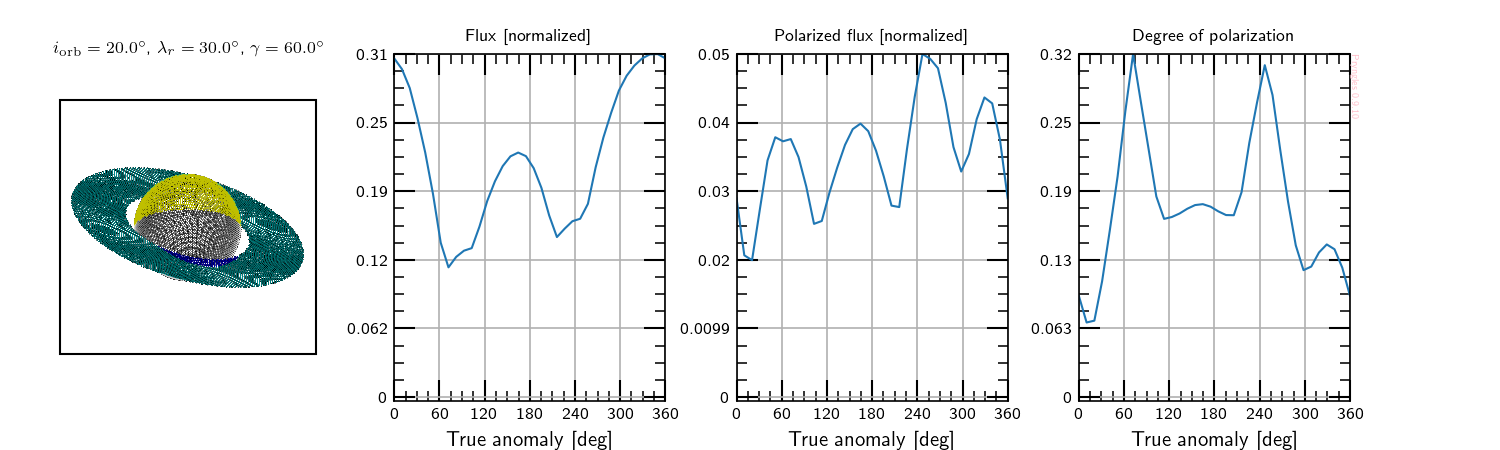

Saving figures/test_polarimetry-io_20.0-rl_30.0-ri_60.0.png...


In [17]:
# Check normalization
if RP.LC_normalized:
    normfactor = 1
    units = ' [normalized]'
else:
    units = 'ppm'
    normfactor = 1e6
    units = rf' [{units}]'

#Create figure
fsize=1
plt.rcParams.update({'font.size': 8*fsize})
fig = plt.figure(figsize=(10*fsize,3*fsize))
gs = fig.add_gridspec(ncols=4, nrows=1, wspace = 0.3, width_ratios= [0.5,1,1,1])
axs = gs.subplots(sharex=True)

# Get configuration image
figure_loc = fig_dir + f"config-oi_{iorb}-rl_{lambr}-ri_{gamma}-obs.png"
figure = cv.imread(figure_loc)
b,g,r = cv.split(figure)
tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
tmp,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
rgba = [r,g,b,alp]
figure = cv.merge(rgba,4)

# Add image and labels
imagebox = OffsetImage(figure,zoom=0.08)
ab = AnnotationBbox(imagebox,(0.5,0.5),frameon=True,transform=axs[0].transAxes)
axs[0].add_artist(ab)
axs[0].text(1,1,rf'$i_{{\rm orb}} = {iorb}^\circ$, $\lambda_r = {lambr}^\circ$, $\gamma = {gamma}^\circ$',
            ha='right',transform=axs[0].transAxes,fontsize=8*fsize)
axs[0].set_axis_off()

# Plot light-curve
axs[1].plot(true_anomaly,LC[:,1]*normfactor,linestyle='-',linewidth=1*fsize)
axs[2].plot(true_anomaly,LC[:,2]*normfactor,linestyle='-',linewidth=1*fsize)
axs[3].plot(true_anomaly,abs(LC[:,3]),linestyle='-',linewidth=1*fsize)

#Decoration
axs[1].set_title(f"Flux{units}",fontsize=8*fsize)
axs[2].set_title(f"Polarized flux{units}",fontsize=8*fsize)
axs[3].set_title(f"Degree of polarization",fontsize=8*fsize)

Fmax=LC[:,1].max()*normfactor
PFmax=LC[:,2].max()*normfactor
Pmax=abs(LC[:,3]).max()
dF=Fmax/5
dPF=PFmax/5
dP=Pmax/5
        
notext=True
setup_plot(axs[1],60,0,360,dF,-Fmax/100,Fmax,notext=notext)
setup_plot(axs[2],60,0,360,dPF,-PFmax/100,PFmax,notext=notext)
setup_plot(axs[3],60,0,360,dP,-Pmax/100,Pmax,notext=notext)

for ax in axs[1:]:
    ax.grid()
    ax.set_xlabel("True anomaly [deg]",fontsize=10)

prymark(axs[3])
save_figure(fig,f"test_polarimetry-io_{iorb}-rl_{lambr}-ri_{gamma}", fig_dir=fig_dir, dpi=300, formats=['png'])

You can also produce a non-normalized flux calculation. For instance, to produce fluxes in ppb (parts per billion) use:

In [18]:
LC=RP.compute_polarimetic_curve(lambs,normalize=False,progress=tqdm)

100%|██████████| 36/36 [00:05<00:00,  6.58it/s]


In this case the fluxes are given relative to the stellar flux. We want to plot it in ppm:

<IPython.core.display.Javascript object>


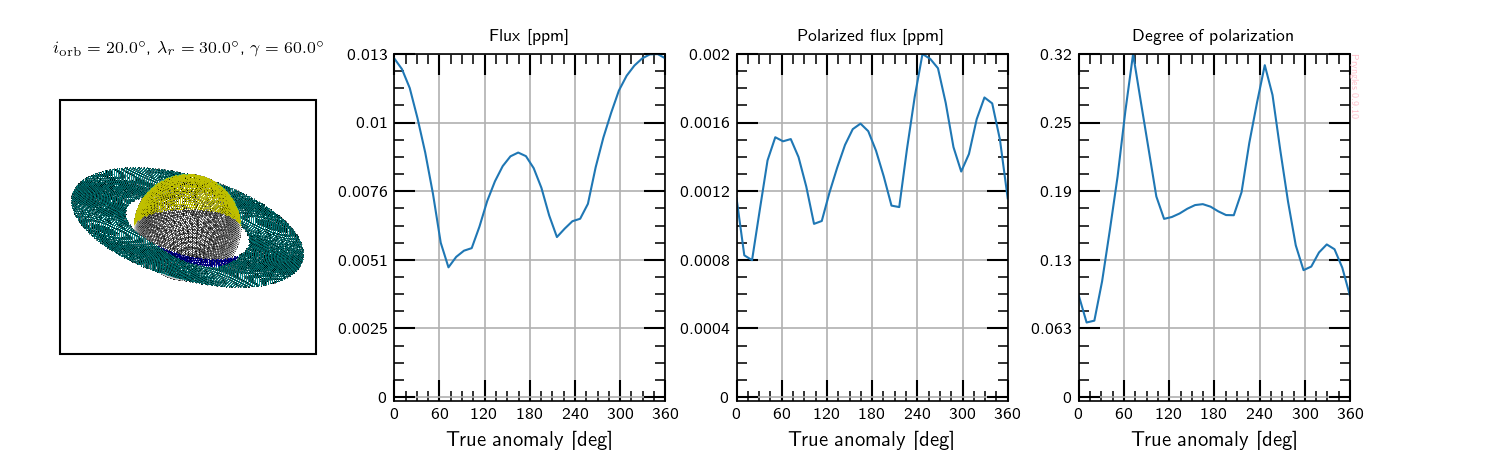

Saving figures/test_polarimetry_absolute-io_20.0-rl_30.0-ri_60.0.png...


In [19]:
# Check normalization
if RP.LC_normalized:
    normfactor = 1
    units = ' [normalized]'
else:
    units = 'ppm'
    normfactor = 1e6
    units = rf' [{units}]'

#Create figure
fsize=1
plt.rcParams.update({'font.size': 8*fsize})
fig = plt.figure(figsize=(10*fsize,3*fsize))
gs = fig.add_gridspec(ncols=4, nrows=1, wspace = 0.3, width_ratios= [0.5,1,1,1])
axs = gs.subplots(sharex=True)

# Get configuration image
figure_loc = fig_dir + f"config-oi_{iorb}-rl_{lambr}-ri_{gamma}-obs.png"
figure = cv.imread(figure_loc)
b,g,r = cv.split(figure)
tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
tmp,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
rgba = [r,g,b,alp]
figure = cv.merge(rgba,4)

# Add image and labels
imagebox = OffsetImage(figure,zoom=0.08)
ab = AnnotationBbox(imagebox,(0.5,0.5),frameon=True,transform=axs[0].transAxes)
axs[0].add_artist(ab)
axs[0].text(1,1,rf'$i_{{\rm orb}} = {iorb}^\circ$, $\lambda_r = {lambr}^\circ$, $\gamma = {gamma}^\circ$',
            ha='right',transform=axs[0].transAxes,fontsize=8*fsize)
axs[0].set_axis_off()

# Plot light-curve
axs[1].plot(true_anomaly,LC[:,1]*normfactor,linestyle='-',linewidth=1*fsize)
axs[2].plot(true_anomaly,LC[:,2]*normfactor,linestyle='-',linewidth=1*fsize)
axs[3].plot(true_anomaly,abs(LC[:,3]),linestyle='-',linewidth=1*fsize)

#Decoration
axs[1].set_title(f"Flux{units}",fontsize=8*fsize)
axs[2].set_title(f"Polarized flux{units}",fontsize=8*fsize)
axs[3].set_title(f"Degree of polarization",fontsize=8*fsize)

Fmax=LC[:,1].max()*normfactor
PFmax=LC[:,2].max()*normfactor
Pmax=abs(LC[:,3]).max()
dF=Fmax/5
dPF=PFmax/5
dP=Pmax/5
        
notext=True
setup_plot(axs[1],60,0,360,dF,-Fmax/100,Fmax,notext=notext)
setup_plot(axs[2],60,0,360,dPF,-PFmax/100,PFmax,notext=notext)
setup_plot(axs[3],60,0,360,dP,-Pmax/100,Pmax,notext=notext)

for ax in axs[1:]:
    ax.grid()
    ax.set_xlabel("True anomaly [deg]",fontsize=10)

prymark(axs[3])
save_figure(fig,f"test_polarimetry_absolute-io_{iorb}-rl_{lambr}-ri_{gamma}", fig_dir=fig_dir, dpi=300, formats=['png'])

## Automatizing polarimetric light-curve generation

Now we have tested how to configure a system and produce polarimetric light-curves we can write a general set of tools to explore the parameter space. It is important to stress that the tools below are not part of `Pryngles`. Users can create their own personalized set of tools.

For the exploration of the parameter space we will create a class `Parameters`.  This class essentially encapsulate the list of *key* parameters (but not all of them) determining the polarimetric light-curve. We call a particular set of parameters a **model**.

The class has three methods: 1) `update_properties` which takes the attributes of the object (parameters) and calculate some derived parameters), 2) `get_name` that generate a unique string identifying each model, and 3) `plot_polarimetric_curve` which produces a nice plot of the polarimetric light-curve for the provided parameters.

This class and methods are based entirely in the code presented before.

In [20]:
class Parameters(object):
    def __init__(self,**entries):
        self.__dict__.update(entries)
        
        # Normalization
        if 'normalize' not in self.__dict__.keys():
            self.normalize = True
                 
    def get_name(self):
        """Generate the name of a given model from the basic parameters
        """
        variables=OrderedDict(
            N=int(self.normalize),
            io=self.iorb,rl=self.lambr,ri=self.gamma,
            br=self.tau_ring,omr=self.omegar,bp=self.bp,omp=self.omegap,
            rin=self.ring_ri,rou=self.ring_re,
            a=self.a,e=self.e,Rs=self.Rs,Rp=self.Rp
        )
        name=''
        for key,val in variables.items():
            name+=f'{key}_{val:.2f}-'
        return name[:-1]
    
    def update_properties(self,quiet=False):
        
        # Orientation w.r.t. ecliptic
        self.ir, self.beta_obs, self.lamb_obs, self.lamb_star = pr.Util.calcStartingPosition(self.iorb,
                                                                                             self.gamma,
                                                                                             self.lambr)

        # Fourier coefficients file
        self.fou_file_planet = f'fou_bmsca{self.bp:.1f}_asurf{self.omegap:.1f}.dat'
        
        # If tau_ring == 0 then no ring is present, but no fou file is available
        br = self.tau_ring if self.tau_ring > 0.0 else 1.0
        self.fou_file_ring = f'fou_ring_{str(br).replace(".","_")}_{str(self.omegar).replace(".","_")}.dat'

        # Check if coefficients file are available in data repo 
        pr.Misc.retrieve_data([self.fou_file_planet,self.fou_file_ring],
                              path=tmp_dir,overwrite=False,quiet=quiet)
        
        # Generate name for this simulation
        self.name = self.get_name()
        
        # Normalization
        if 'normalize' not in self.__dict__.keys():
            self.normalize = True
           
        if not quiet:
            print(f"Fourier coefficients files required: {[self.fou_file_planet,self.fou_file_ring]}")
            print(f"Initial conditions in the planet-centered system are:")
            print(f"\tRing inclination w.r.t. ecliptic: {self.ir*Consts.rad:.1f} deg")
            print(f"\tInclination of the observer w.r.t ecliptic: {self.beta_obs*Consts.rad:.1f} deg")
            print(f"\tInitial longitude of the observer: {self.lamb_obs*Consts.rad:.1f} deg")
            print(f"\tInitial longitude of the star: {self.lamb_star*Consts.rad:.1f} deg")
            print(f"Model name: {self.name}")
                
    def plot_polarimetric_curve(self,quiet=True,fsize=1):
        """Plot the polarimetric light-curve
        """
        
        if quiet:
            plt.ioff()

        # Check normalization
        if self.LC_normalized:
            normfactor = 1
            units = ' [normalized]'
        else:
            normfactor = self.normfactor
            units = rf' [{self.units}]'
    
        #Create figure
        plt.rcParams.update({'font.size': 8*fsize})
        fig = plt.figure(figsize=(10*fsize,3*fsize))
        gs = fig.add_gridspec(ncols=4, nrows=1, wspace = 0.3, width_ratios= [0.5,1,1,1])
        axs = gs.subplots(sharex=True)

        # Get configuration image
        figure_loc = fig_dir + f"config-{self.name}-obs.png"
        figure = cv.imread(figure_loc)
        b,g,r = cv.split(figure)
        tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
        tmp,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
        rgba = [r,g,b,alp]
        figure = cv.merge(rgba,4)

        # Add image and labels
        imagebox = OffsetImage(figure,zoom=0.08)
        ab = AnnotationBbox(imagebox,(0.5,0.5),frameon=True,transform=axs[0].transAxes)
        axs[0].add_artist(ab)
        axs[0].text(1,1,rf'$i_{{\rm orb}} = {self.iorb:.1f}^\circ$, $\lambda_r = {self.lambr:.1f}^\circ$, $\gamma = {self.gamma:.1f}^\circ$',
                    ha='right',transform=axs[0].transAxes,fontsize=8*fsize)
        axs[0].set_axis_off()

        # Plot light-curve
        axs[1].plot(self.true_anomaly,self.LC[:,1]*normfactor,linestyle='-',linewidth=1*fsize)
        axs[2].plot(self.true_anomaly,self.LC[:,2]*normfactor,linestyle='-',linewidth=1*fsize)
        axs[3].plot(self.true_anomaly,abs(self.LC[:,3]),linestyle='-',linewidth=1*fsize)

        #Decoration
        axs[1].set_title(f"Flux{units}",fontsize=8*fsize)
        axs[2].set_title(f"Polarized flux{units}",fontsize=8*fsize)
        axs[3].set_title(f"Degree of polarization",fontsize=8*fsize)

        # Range of the vertical axis
        Fmax=self.LC[:,1].max()*normfactor
        PFmax=self.LC[:,2].max()*normfactor
        Pmax=abs(self.LC[:,3]).max()
        dF=Fmax/10
        dPF=PFmax/10
        dP=Pmax/10
            
        notext=True
        setup_plot(axs[1],60,0,360,dF,-Fmax/100,Fmax,notext=notext)
        setup_plot(axs[2],60,0,360,dPF,-PFmax/100,PFmax,notext=notext)
        setup_plot(axs[3],60,0,360,dP,-Pmax/100,Pmax,notext=notext)

        for ax in axs[1:]:
            ax.grid()
            ax.set_xlabel("True anomaly [deg]",fontsize=10)

        prymark(axs[3])
        save_figure(fig,f"polarimetry-{self.name}", fig_dir=fig_dir, dpi=300, formats=['png'])
        if quiet:
            plt.ion()

Let's create a model with the parameters with the examples we consider before:

In [21]:
parameters=dict(
    # Geometrical factors
    iorb = 20.0, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = 30.0, 
    gamma = 60.0, # Ring inclination, 90 degrees is edge-on orbit

    # Optical parameters
    tau_ring = 1.0, # Optical thickness of the ring
    omegar = 0.8, # Single scattering albedo of ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of planet surface

    # Planet and ring size
    Rs = Consts.rsun, # Stellar radius in m
    Rp = Consts.rsaturn, # Planet radius in m
    ring_ri = 1.2,
    ring_re = 2.25,

    # Orbital properties
    a = 1, # au
    e = 0, 

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 1000, # Number of spangles in ring
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
    
    # Normalization
    normalize = True,
    
    # If not normalized
    normfactor = 1e6,
    units = 'ppm'
)
ps_model=Parameters(**parameters)
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00


As you may have noticed each model has a string with the value of the key quantities, e.g. `N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00`. This string will be used for naming different products, the preview of the planet ring configuration, the polarimetric light-curve, the pickled data with the results, etc.

Finally, with the purpose of parallelizing the parameter space exploration we need to put all the simulation code together into a routine which receive a model object as an input. Again, all this code encapsulate the procedures explained with detail before.

In [22]:
def polarimetry_exploration(ps,quiet=True):
    
    if not quiet:
        print(f"Running polarimetry simulation for {ps.name}:")
    
    tini = time.time()
    
    # Create a system
    sys = pr.System(units=['au','msun','yr2pi'])

    if not quiet:
        print("\tCreating system...")
    S=sys.add(
        kind="Star",
        physics=dict(radius=ps.Rs/sys.ul),
        optics=dict(limb_coeffs=[0.65])
    )

    P=sys.add(
        kind="Planet", primary=S,
        radius=ps.Rp/sys.ul,
        orbit=dict(a=ps.a, e=ps.e),
        physics=dict(radius=ps.Rp/sys.ul),
        optics=dict(nspangles=ps.Np)
    )

    R=sys.add(
        kind="Ring", primary=P,
        physics=dict(fi=ps.ring_ri, fe=ps.ring_re, i=ps.ir, taur=ps.tau_ring),
        optics=dict(nspangles=ps.Nr)
    )

    RP=sys.ensamble_system(extension=extension,
                           fname_planet=tmp_dir + ps.fou_file_planet,
                           fname_ring=tmp_dir + ps.fou_file_ring)

    if not quiet:
        print("\tUpdating properties...")
        
    # Update additional properties
    RP.behavior["interp_method_ring"] = 'spline'
    RP.reference_plane = 'Detector'
    RP.updatePhysicalProperties(dict(taur = ps.tau_ring))
    RP.iorb = ps.iorb
    RP.gamma = ps.gamma
    RP.alphar = ps.lambr
    RP.Ns = ps.Ns
    RP.Np = ps.Np
    RP.Nr = ps.Nr
    RP.Nb = ps.Nb
    RP.updateProperties()
    
    # Set observer and stellar position
    if not quiet:
        print("\tSetting initial configuration...")
    RP.changeObserver([ps.lamb_obs,ps.beta_obs])
    RP.changeStellarPosition(ps.lamb_star)
    RP.updateSpangles()

    # Save views
    if not quiet:
        print("\tSaving configuration views...")
    save_planet_views(RP,suffix=ps.name,quiet=True)

    # Ecliptic longitude interval
    if not quiet:
        print("\tGenerating light curves...")
    ps.lamb_initial = ps.lamb_star
    ps.lamb_final = ps.lamb_initial + ps.delta_lamb*Consts.deg
    ps.lambs = np.linspace(ps.lamb_initial,ps.lamb_final,ps.nlambs)

    ps.LC=RP.compute_polarimetic_curve(ps.lambs,normalize=ps.normalize,
                                       progress=ps.progress)
    ps.LC_normalized = RP.LC_normalized
    ps.true_anomaly = (ps.LC[:,0]-ps.lamb_initial)*Consts.rad
    
    # Generate polarimetric light-curve
    if not quiet:
        print("\tPlotting light curves...")
    ps.plot_polarimetric_curve(quiet=quiet)
    
    tend=time.time()
    if not quiet:
        print(f"\tRunning time: {tend-tini} seconds")
    
    # Pickle polarimetric data
    if not quiet:
        print("\tPickling result...")
    save_dict = dict()
    no_save = dict()
    for key,val in ps.__dict__.items():
        if type(val) in [bool,int,float,np.int64,np.float64,np.ndarray,str]:
            save_dict[key] = val
        else:
            no_save[key] = val
    if not quiet:
        print(f"\t\tPickling variables: {save_dict.keys()}...")
        print(f"\t\tAvoiding to pickle variables: {no_save.keys()}...")
    
    with open(tmp_dir + f"data_{ps.name}.pkl","wb") as f:
        pickle.dump(save_dict, f)
        
    return ps

## Model example

Let's test our tools by using the previously define model and the routine `polarimetry_exploration`. As you may notice in the code below, we start by creating a *deep copy* of an example model object (`ps_model`) and then we change some of the parameters before proceeding calculating the polarimetric light-curve:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00

100%|██████████| 36/36 [00:01<00:00, 24.94it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


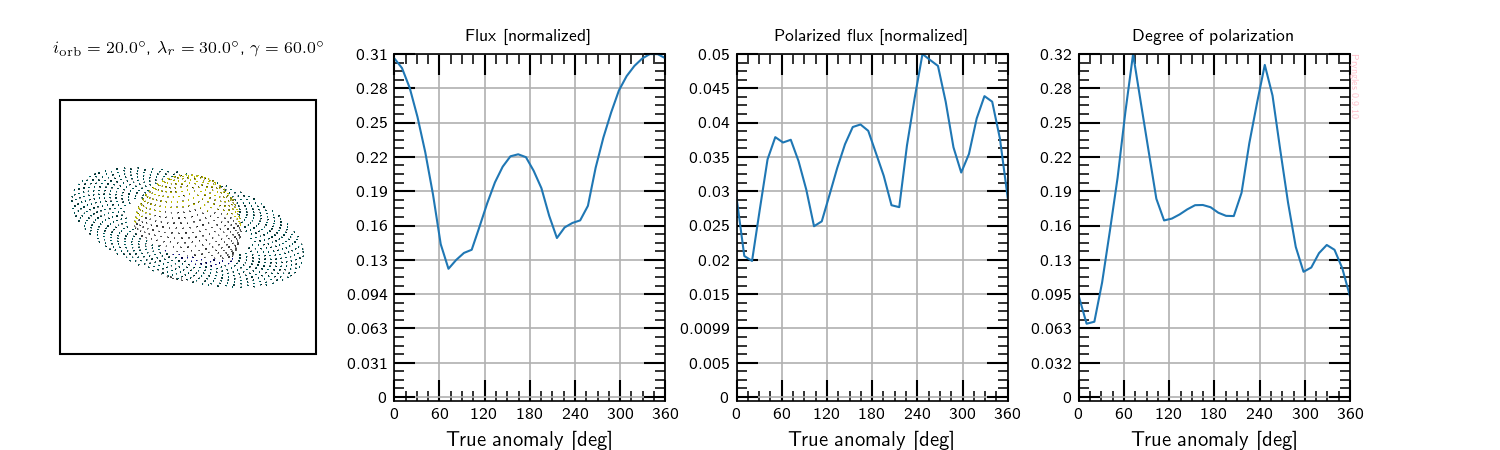

Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 7.949881076812744 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [23]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.Nr = 1000
ps_new.nlambs = 36
ps_new.normalize = True
ps_new.update_properties(quiet=False)
polarimetry_exploration(ps_new,quiet=False)

## Paper experiments

### Experiment: ring-less planet at different viewing angles

For this experiment we need first to create a proper parameter set and test it:

In [24]:
parameters=dict(   
    # Geometrical factors
    iorb = 20.0, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = 0.0, # 
    gamma = 80.0, # <- This will ensure the ring does not block the planet

    # Optical parameters
    tau_ring = 0.0, # Optical thickness of the ring
    omegar = 0.8, # Single scattering albedo of ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of planet surface

    # Planet and ring size
    Rs = Consts.rsun, # Stellar radius in m
    Rp = Consts.rsaturn, # Planet radius in m
    ring_ri = 2.0,
    ring_re = 2.25,

    # Orbital properties
    a = 1, # au
    e = 0, 

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 100, # Number of spangles in ring <- Not much ring particles required
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
    
    # Normalization
    normalize = True,
    
    # If not normalized
    normfactor = 1e6,
    units = 'ppm'
)
ps_model=Parameters(**parameters)
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00


Let's run it:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e

100%|██████████| 36/36 [00:01<00:00, 27.73it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


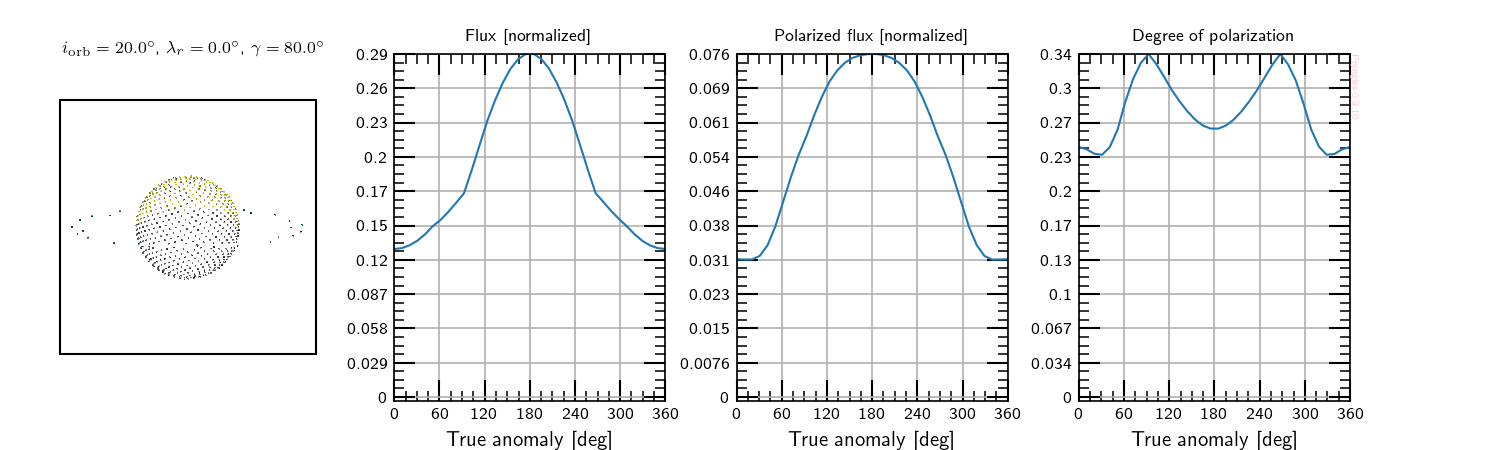

Saving figures/polarimetry-N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 8.300602197647095 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [25]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.nlambs = 36
ps_new.update_properties(quiet=False)
ps=polarimetry_exploration(ps_new,quiet=False)

Since this experiment only require plotting the flux coming from the planet we just need the proper columns from the LC:

- Column 0: lambda [degrees]
- Column 1: Total flux, Stot
- Column 2: Polarized flux, Pflux
- Column 3: Total degree of polarization, Ptot
- Column 4: Phase angle [degrees], alpha
- Columns 5,6,7 (5:8): Total stokes vector (F,Q,U), Stot[]
- Columns 8,9,10 (8:11): Planet stokes vector (F,Q,U), Stotp[]
- Columns 11,12,13 (11:14): Ring stokes vector (F,Q,U), Stotr[]
- Column 14: Degree of polarization planet, Ptotp
- Column 15: Degree of polarization ring, Ptotr

This a fancier plot closer to that which will appear in the paper:

<IPython.core.display.Javascript object>


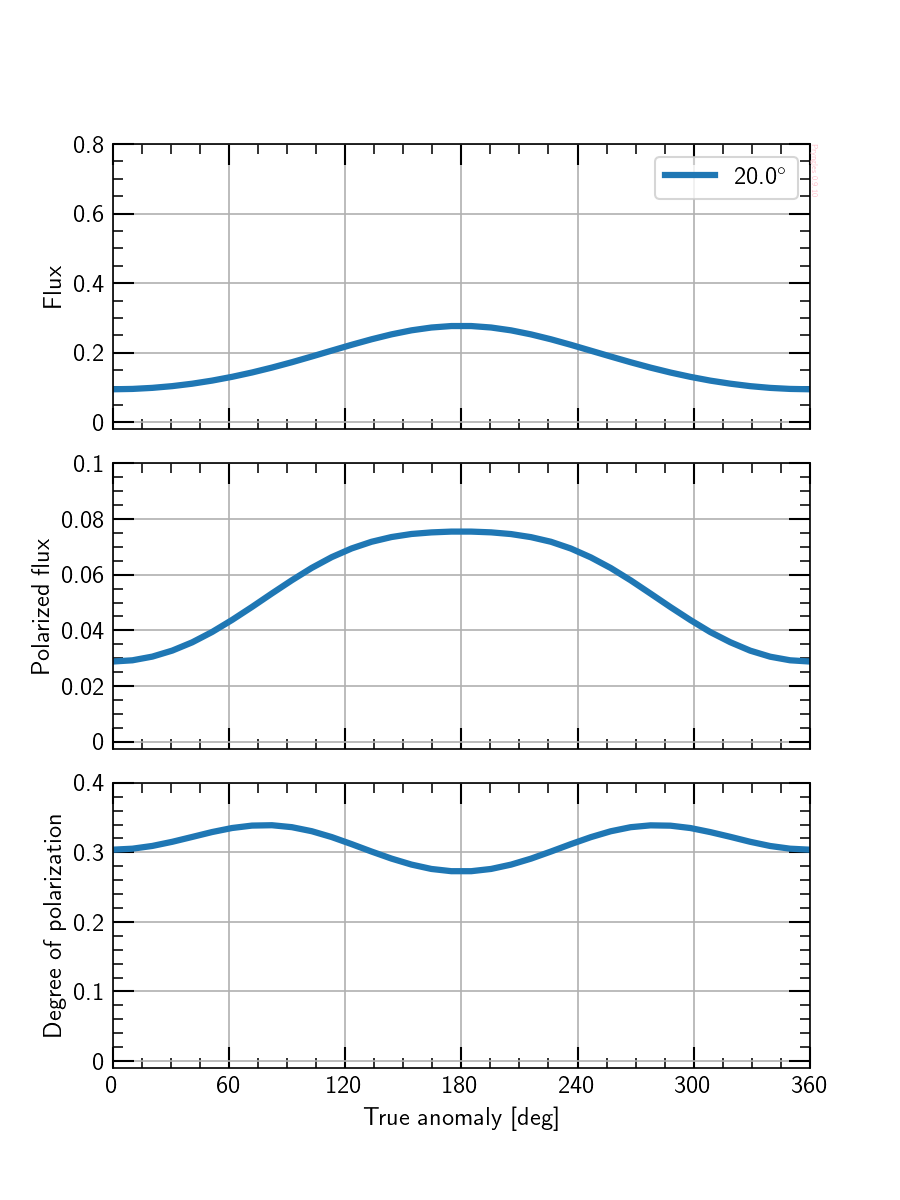

Text(1, 1, 'Pryngles 0.9.10')

In [26]:
# Extract the data only for the planet
Fluxp = ps.LC[:,8]
Pfluxp = (ps.LC[:,9]**2+ps.LC[:,10]**2)**0.5
Pp = ps.LC[:,14]

notext = False
fsize = 2
fig = plt.figure(figsize=(3*fsize,4*fsize))

plt.rcParams.update({'font.size': 6*fsize})
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

i = 0
plot_line = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
axs[0].plot(ps.true_anomaly,Fluxp,linestyle=plot_line[i],label=f"{ps.iorb}$^\circ$",linewidth=3)
axs[1].plot(ps.true_anomaly,Pfluxp,linestyle=plot_line[i],label=f"Inclination {ps.iorb}",linewidth=3)
axs[2].plot(ps.true_anomaly,abs(Pp),linestyle=plot_line[i],label=f"Inclination {ps.iorb}",linewidth=3)
    
axs[0].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
    
setup_plot(axs[0],60,0,360,0.2,-0.02,0.8,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.1,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")
prymark(axs[0])

Now it's time for some actions. We will now to change one of the parameters of the model to create a **model set**:

In [27]:
iorbs = np.array([0,10,20,30,40,50,60,70,80,90])
ps_set = []
for iorb in iorbs:
    ps_new=deepcopy(ps_model)
    ps_new.iorb=iorb
    ps_new.progress=notqdm
    ps_new.Np = 1000
    ps_new.nlambs = 36
    ps_new.update_properties(quiet=True)
    ps_set += [ps_new]
print(f"Exploration set with {len(ps_set)} simulations")

Exploration set with 10 simulations


You may run this set of models sequentially. However if you are in a good machine you can distribute the models among processors.  For this purpose we will use the *simple* `joblib` library:

In [28]:
# Other backends = 'threading', 'sequential', 'multiprocessing'
# backend='sequential';quiet = False # <- Uncomment for a test run
backend='loky'; quiet = True
n_jobs = number_processors
tini=time.time()
joblib.Parallel(n_jobs=n_jobs,
                backend=backend,verbose=50)(joblib.delayed(polarimetry_exploration)(ps, quiet = True) for ps in ps_set)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=6)]: Done   2 out of  10 | elapsed:   20.5s remaining:  1.4min
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:   20.6s remaining:   48.0s
[Parallel(n_jobs=6)]: Done   4 out of  10 | elapsed:   20.7s remaining:   31.1s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:   21.0s remaining:   21.0s
[Parallel(n_jobs=6)]: Done   6 out of  10 | elapsed:   21.0s remaining:   14.0s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:   28.9s remaining:   12.4s
[Parallel(n_jobs=6)]: Done   8 out of  10 | elapsed:   29.9s remaining:    7.5s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   30.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   30.0s finished
Parallel execution time = 29.975142002105713


Once the results of the model set are ready we can proceed at plotting the results together:

<IPython.core.display.Javascript object>


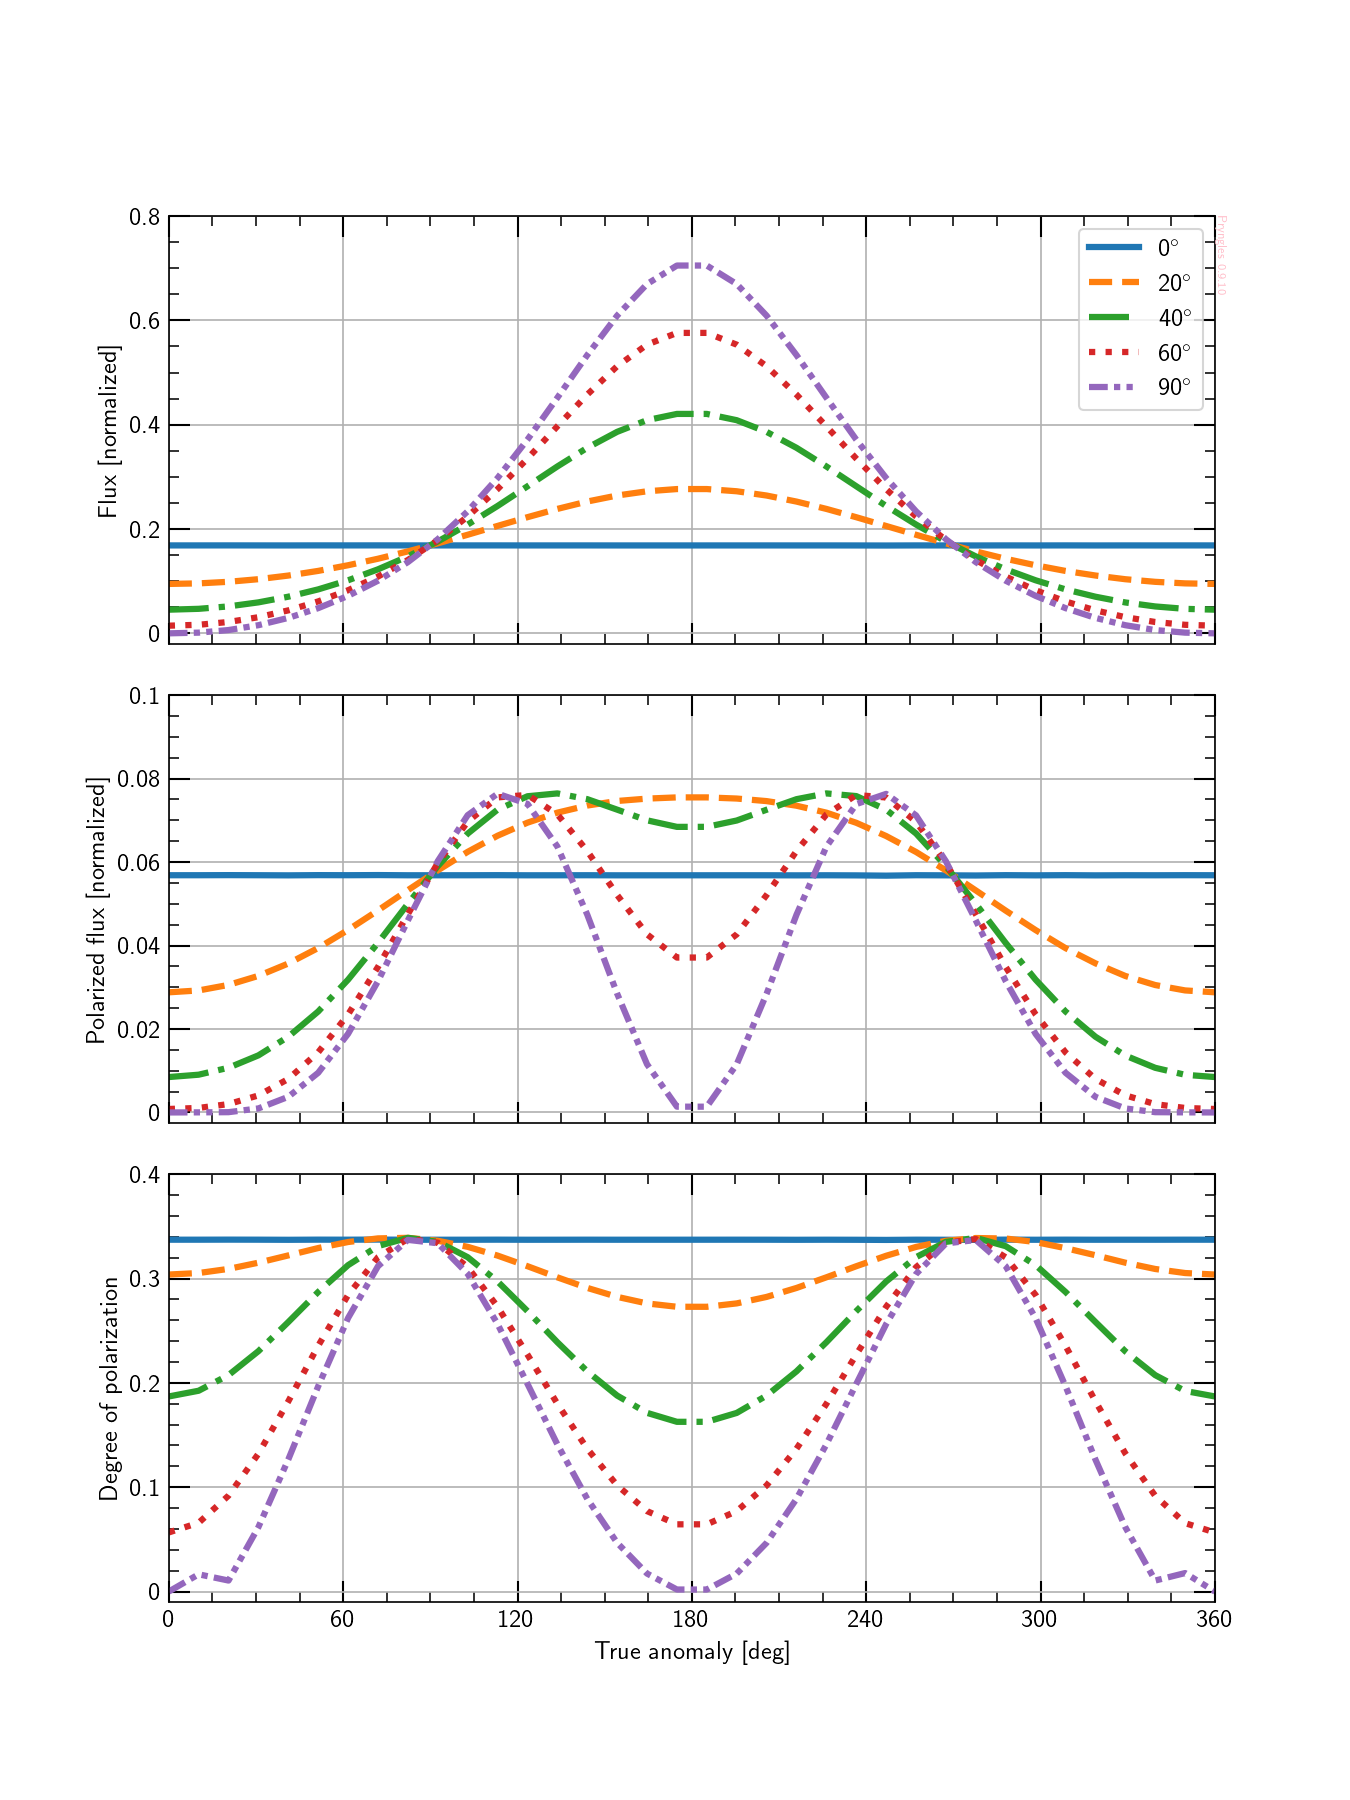

Text(1, 1, 'Pryngles 0.9.10')

In [29]:
# What to plot
iorbs = np.array([0,20,40,60,90])

# Figure
notext = False
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

# Line styles
plot_line = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
n_lines = len(plot_line)

ps = deepcopy(ps_model)
for i, iorb in enumerate(iorbs):
    
    ps.iorb = iorb
    ps.update_properties(quiet = True)
    name = ps.get_name()
    data_name = tmp_dir + f"data_{name}.pkl"
    
    with open(data_name,"rb") as f:
        data = pickle.load(f)
        ps = Parameters(**data)

    # Get data
    Fluxp = ps.LC[:,8]
    Pfluxp = (ps.LC[:,9]**2+ps.LC[:,10]**2)**0.5
    Pp = ps.LC[:,14]
        
    axs[0].plot(ps.true_anomaly,Fluxp,linestyle=plot_line[i%n_lines],label=f"{ps.iorb}$^\circ$",linewidth=3)
    axs[1].plot(ps.true_anomaly,Pfluxp,linestyle=plot_line[i%n_lines],label=f"Inclination {ps.iorb}",linewidth=3)
    axs[2].plot(ps.true_anomaly,abs(Pp),linestyle=plot_line[i%n_lines],label=f"Inclination {ps.iorb}",linewidth=3)
    
# Decoration
axs[0].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
    
setup_plot(axs[0],60,0,360,0.2,-0.02,0.8,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.1,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux [normalized]")
axs[1].set_ylabel("Polarized flux [normalized]")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")
prymark(axs[0])

Since this is our first final image for the paper let's create image files with different formats and the maximum resolution:

In [30]:
save_figure(fig,"Orbit_incl", fig_dir=fig_final_dir, dpi=600, formats=['png','svg','eps'])

Saving figures/final/Orbit_incl.png...
Saving figures/final/Orbit_incl.svg...
Saving figures/final/Orbit_incl.eps...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Experiment: varying ring optical thickness

Now we will vary the optical-tickness of the ring (`tau_ring` or $b_r$).

In preparation for this experiment we need to download all the required Fourier coefficients files:

In [31]:
omegar = 0.8
tau_rings=np.array([0.01,0.05,0.1,0.2,0.4,0.8,1.0,1.6,2.0,4.0])

for tau_ring in tau_rings:
    br = tau_ring if tau_ring > 0 else 0
    fou_file_ring = f'fou_ring_{str(br).replace(".","_")}_{str(omegar).replace(".","_")}.dat'
    pr.Misc.retrieve_data([fou_file_ring],path=tmp_dir, overwrite=False, quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_0_01_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_01_0_8.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_0_05_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_05_0_8.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_0_1_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_1_0_8.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_0_2_0_8.dat already retrieved. For 

As usual we prepare the model

In [32]:
ps_model=Parameters(**dict(
    # Geometrical factors
    iorb = 20.0, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = 30.0, 
    gamma = 60.0, # Ring inclination, 90 degrees is edge-on orbit

    # Optical parameters
    tau_ring = 0.01, # Optical thickness of the ring
    omegar = 0.8, # Single scattering albedo of the ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of the planet surface

    # Planet and ring size
    Rs = Consts.rsun, # Stellar radius in m
    Rp = Consts.rsaturn, # Planet radius in m
    ring_ri = 1.2,
    ring_re = 2.25,

    # Orbital properties
    a = 1, # au
    e = 0, 

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 1000, # Number of spangles in ring
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
    
    # Normalization
    normalize = True,

    # If not normalized
    normfactor = 1e6,
    units = 'ppm'
))
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_0_01_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_0_01_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_0_01_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_0.01-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00


And test it:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_0_01_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_0_01_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_0_01_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_0.01-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_30.00-ri_60.00-br_0.01-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1

100%|██████████| 36/36 [00:01<00:00, 24.52it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


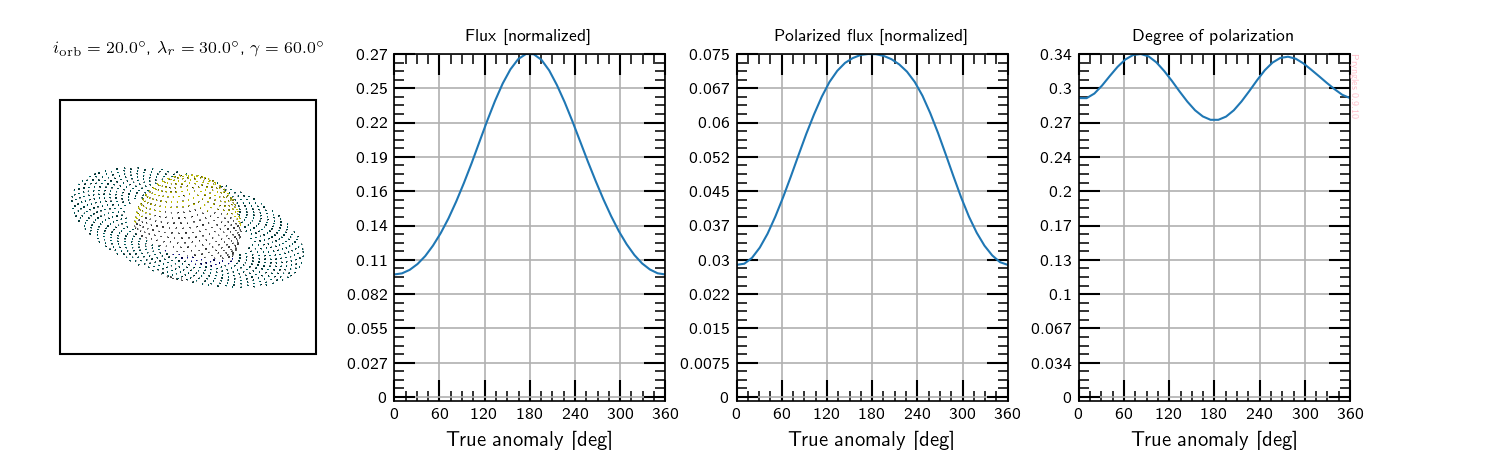

Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_0.01-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 7.8952531814575195 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [33]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.nlambs = 36
ps_new.update_properties(quiet=False)
ps_new=polarimetry_exploration(ps_new,quiet=False)

The fancy, paper-like plot will be:

<IPython.core.display.Javascript object>


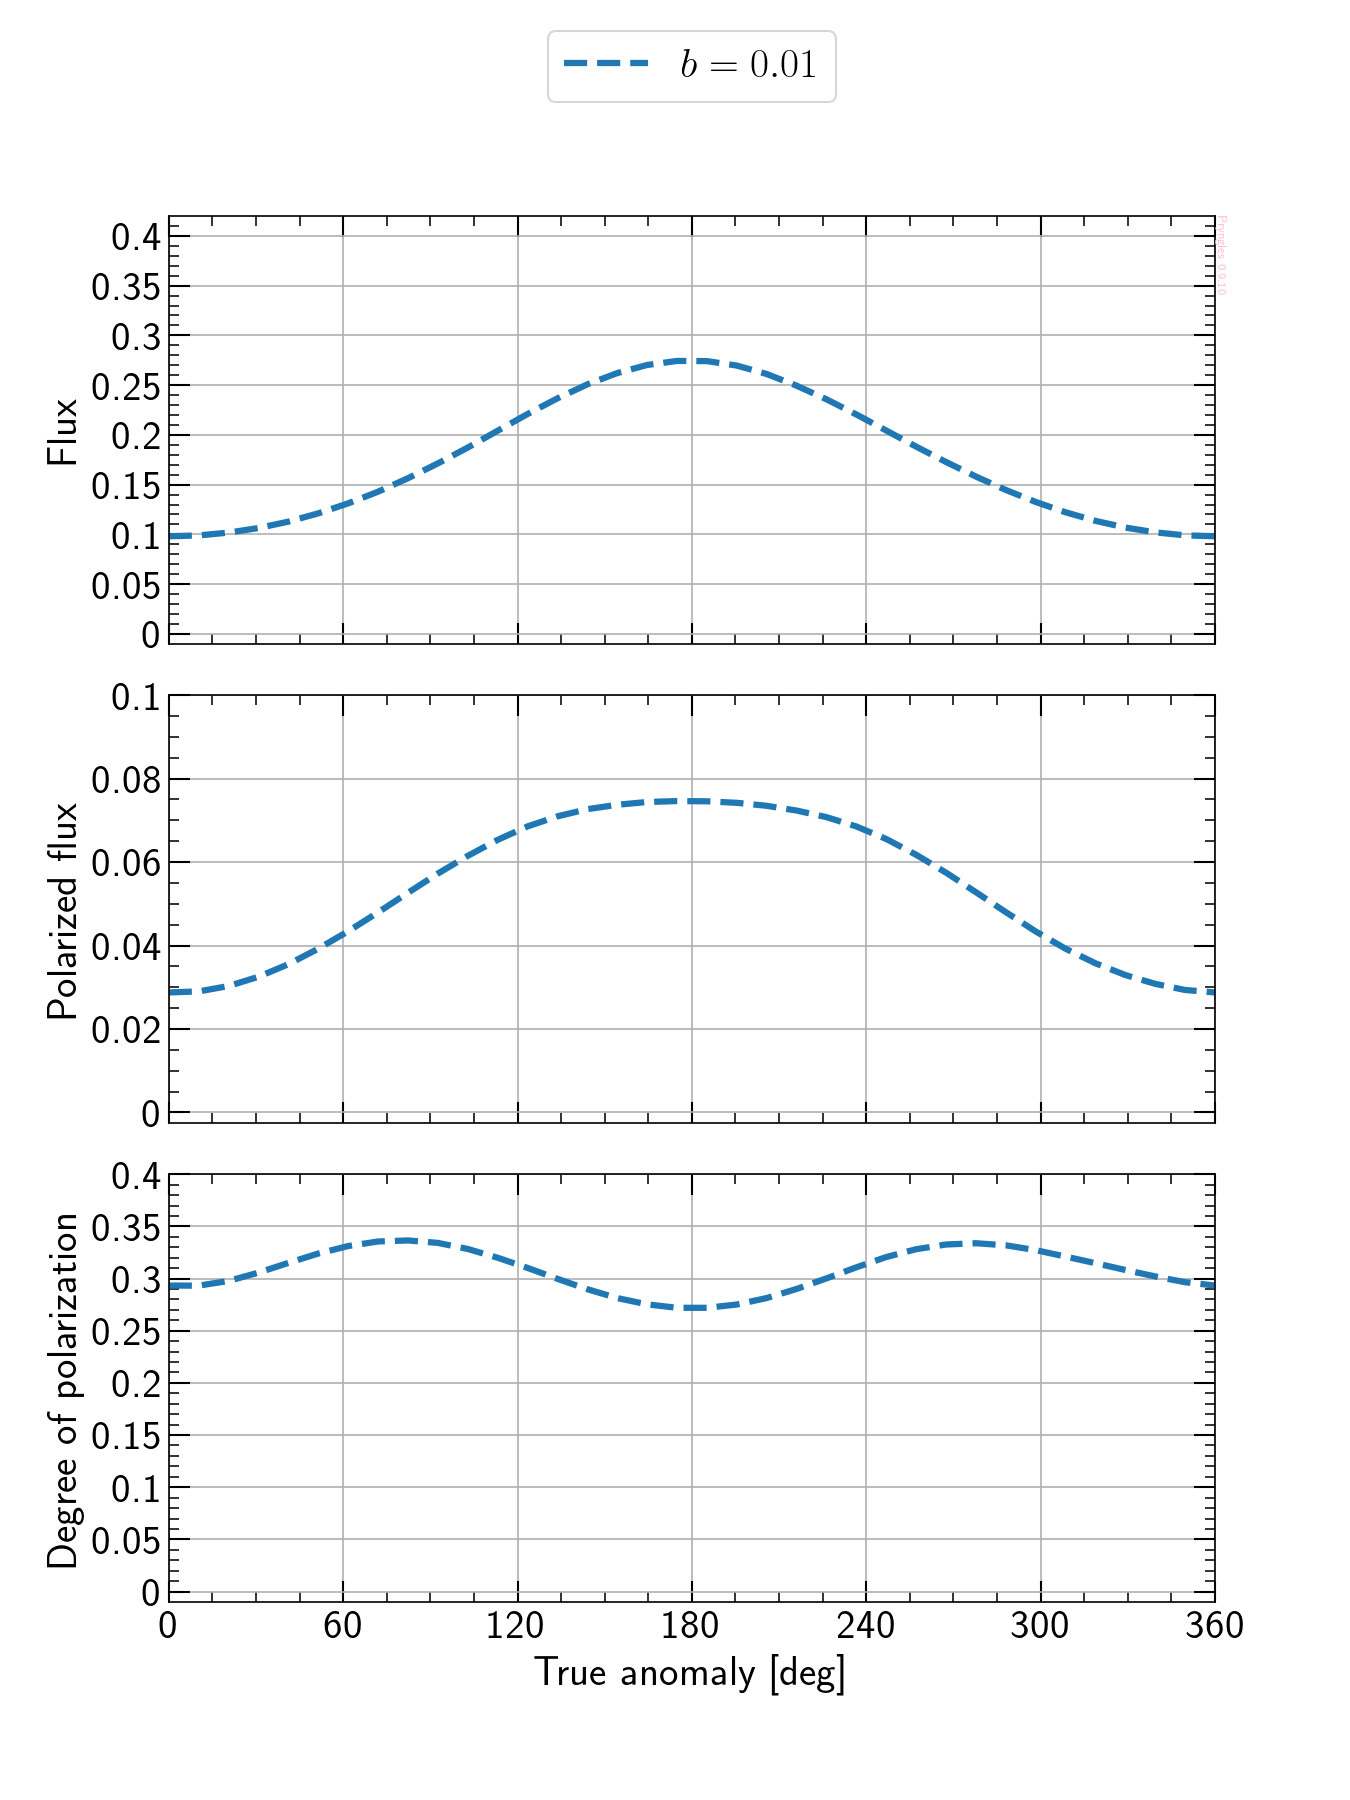

Text(1, 1, 'Pryngles 0.9.10')

In [34]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]

# Total flux
axs[0].plot(ps_new.true_anomaly,ps_new.LC[:,1],linestyle="--",label=f"$b={ps_new.tau_ring}$",linewidth=3)
axs[1].plot(ps_new.true_anomaly,ps_new.LC[:,2],linestyle="--",linewidth=3)
axs[2].plot(ps_new.true_anomaly,abs(ps_new.LC[:,3]),linestyle="--",linewidth=3)
                
# Decorate    
axs[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.48),ncol=4)
for ax in axs:
    ax.grid()

notext = False
setup_plot(axs[0],60,0,360,0.05,-0.01,0.42,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.05,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")
prymark(axs[0])

We want to compare this with the ring-less case. For this purpose we need first to calculate the light-curve for this case.  This is tricky since we need to keep all parameters but to change some of the ring properties.  Here is the correspinding ring-less case:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e

100%|██████████| 36/36 [00:01<00:00, 27.19it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


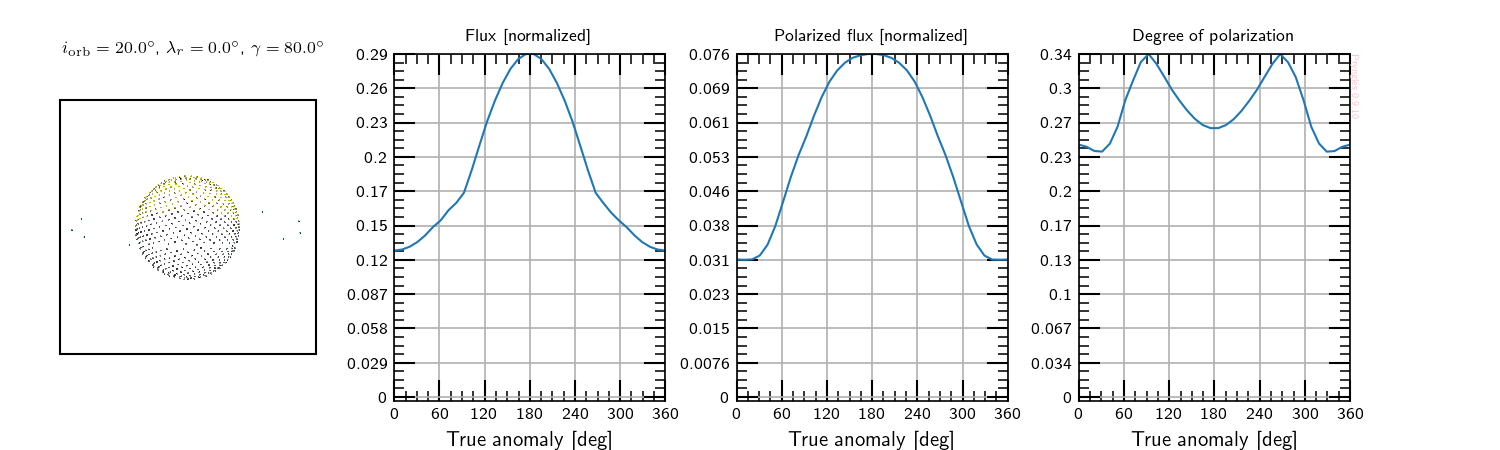

Saving figures/polarimetry-N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 7.462384223937988 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [35]:
ps_rl = deepcopy(ps_model)
ps_rl.progress=tqdm
ps_rl.Np = 1000
ps_rl.nlambs = 36
ps_rl.tau_ring = 0
ps_rl.Nr = 30
ps_rl.lambr = 0.0
ps_rl.gamma = 80.0
ps_rl.ring_ri = 2.0
ps_rl.ring_re = 2.25
ps_rl.update_properties(quiet=False)
ps_rl=polarimetry_exploration(ps_rl,quiet=False)

Now that the ring-less case we can it to compare with the ringed case. Please noticed how the results for the ring-less planet is extracted from the pickle file instead that from an actual simulation. This will be very convenient for many parameter exploration experiments and plots:

<IPython.core.display.Javascript object>


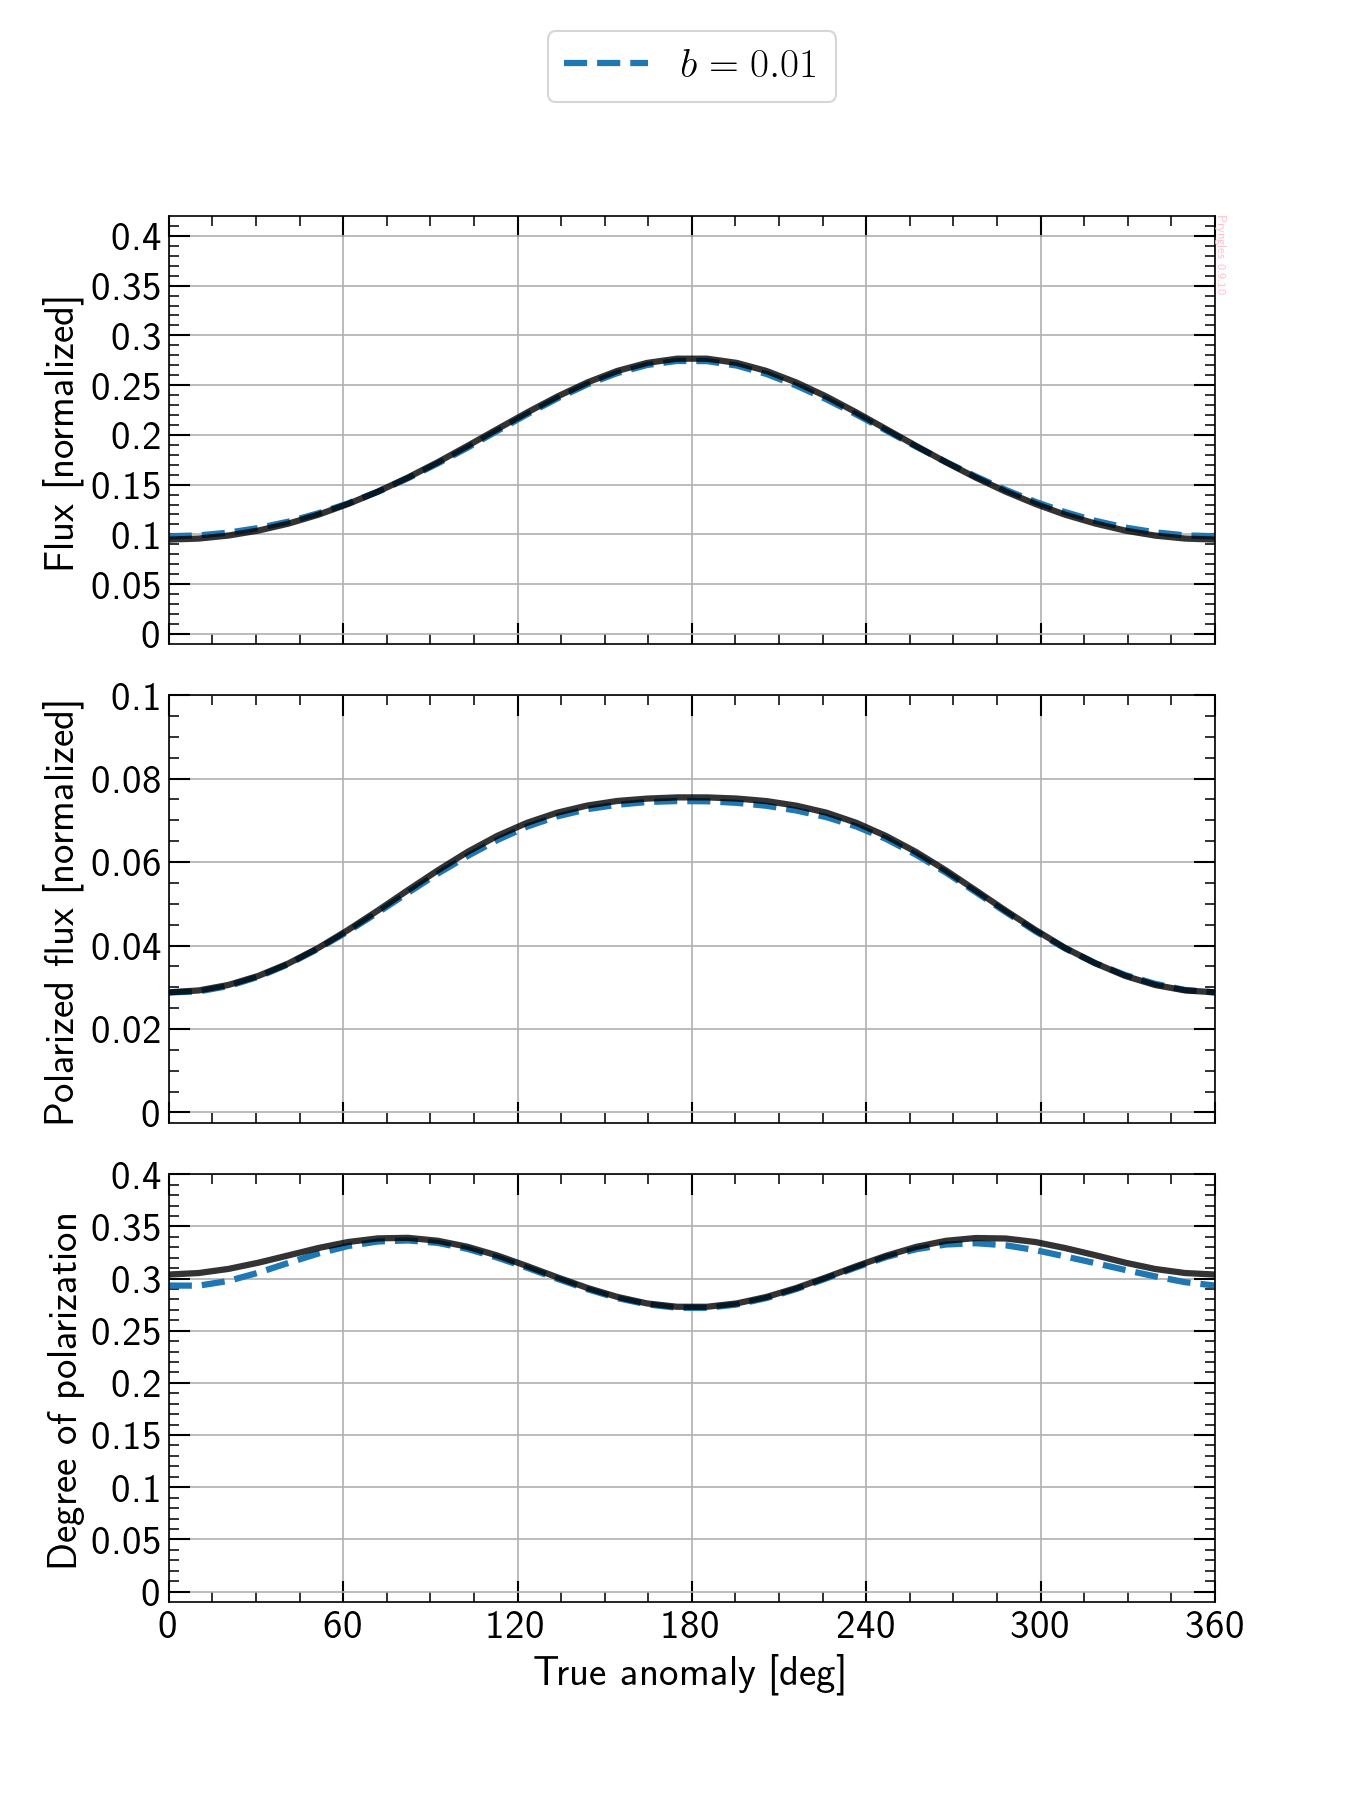

Text(1, 1, 'Pryngles 0.9.10')

In [36]:
plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

# Total flux
axs[0].plot(ps_new.true_anomaly,ps_new.LC[:,1],linestyle="--",label=f"$b={ps_new.tau_ring}$",linewidth=3)
axs[1].plot(ps_new.true_anomaly,ps_new.LC[:,2],linestyle="--",linewidth=3)
axs[2].plot(ps_new.true_anomaly,abs(ps_new.LC[:,3]),linestyle="--",linewidth=3)

# Planetary flux
pname = ps_new.name
pname = re.sub('br_\d+\.\d+','br_0.00',pname)
pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
data_name = tmp_dir + f"data_{pname}.pkl"    
with open(data_name,"rb") as f:
    data = pickle.load(f)
    ps_rl = Parameters(**data)
Fluxp = ps_rl.LC[:,8]
Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
Pp = ps_rl.LC[:,14]
axs[0].plot(ps_new.true_anomaly,Fluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[1].plot(ps_new.true_anomaly,Pfluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[2].plot(ps_new.true_anomaly,abs(Pp),linestyle="-",color="k",linewidth=3,alpha=0.8)
                
# Decorate    
axs[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.48),ncol=4)
for ax in axs:
    ax.grid()

notext = False
setup_plot(axs[0],60,0,360,0.05,-0.01,0.42,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.05,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux [normalized]")
axs[1].set_ylabel("Polarized flux [normalized]")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")
prymark(axs[0])

Now let's generalize this for different values to the ring optical thickness:

In [37]:
tau_rings=np.array([0.01,0.05,0.1,0.2,0.4,0.8,1.0,1.6,2.0,4.0])
ps_set = []
for tau_ring in tau_rings:
    ps_new=deepcopy(ps_model)
    ps_new.progress=notqdm
    ps_new.Np = 1000
    ps_new.nlambs = 36
    ps_new.tau_ring = tau_ring
    ps_new.update_properties(quiet=True)
    ps_set += [ps_new]
print(f"Exploration set with {len(ps_set)} simulations")

Exploration set with 10 simulations


Run them in parallel:

In [38]:
# Other backends = 'threading', 'sequential', 'multiprocessing'
backend='loky';quiet = True
#backend = 'sequential';quiet = False
n_jobs = joblib.cpu_count()-2
tini=time.time()
joblib.Parallel(n_jobs=n_jobs,
                backend=backend,verbose=50)(joblib.delayed(polarimetry_exploration)(ps, quiet = quiet) for ps in ps_set)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   15.2s
[Parallel(n_jobs=6)]: Done   2 out of  10 | elapsed:   15.3s remaining:  1.0min
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:   15.5s remaining:   36.1s
[Parallel(n_jobs=6)]: Done   4 out of  10 | elapsed:   15.5s remaining:   23.3s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:   15.6s remaining:   15.6s
[Parallel(n_jobs=6)]: Done   6 out of  10 | elapsed:   15.8s remaining:   10.5s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:   27.5s remaining:   11.8s
[Parallel(n_jobs=6)]: Done   8 out of  10 | elapsed:   27.5s remaining:    6.9s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   27.7s finished
Parallel execution time = 27.72295093536377


Now we can plot them together:

<IPython.core.display.Javascript object>


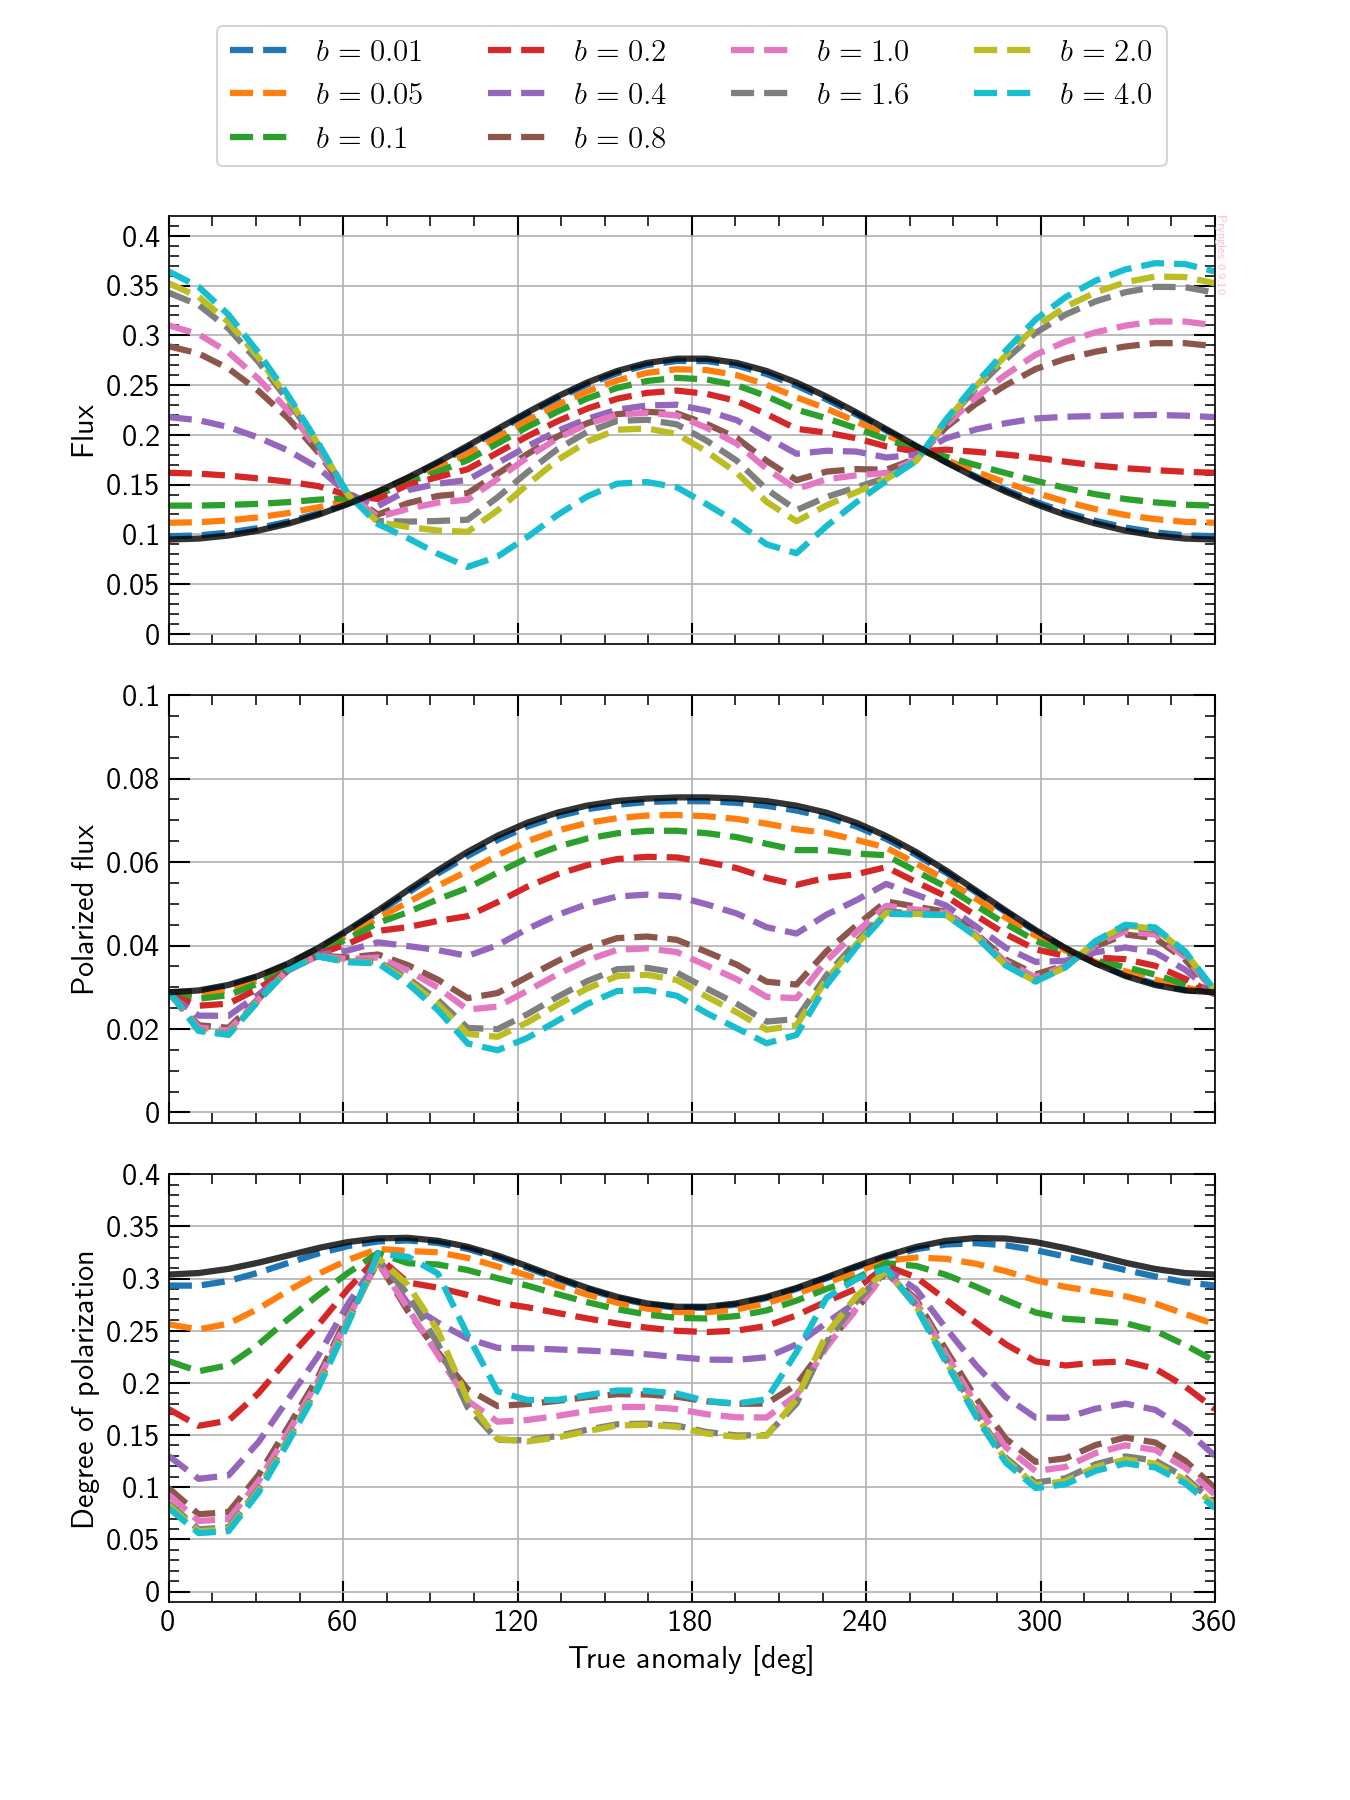

Saving figures/final/Optical_thickness_sweep.png...
Saving figures/final/Optical_thickness_sweep.svg...
Saving figures/final/Optical_thickness_sweep.eps...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(1, 1, 'Pryngles 0.9.10')

In [39]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

ps=deepcopy(ps_model)
correct_order = np.array([0,4,8,1,5,9,2,6,3,7])
for tau_ring in tau_rings:
    
    # Recovering data
    ps_new.tau_ring = tau_ring
    ps_new.update_properties(quiet = True)
    name = ps_new.get_name()
    data_name = tmp_dir + f"data_{name}.pkl"    
    with open(data_name,"rb") as f:
        data = pickle.load(f)
        ps_new = Parameters(**data)
    
    # Total flux
    axs[0].plot(ps_new.true_anomaly,ps_new.LC[:,1],linestyle="--",label=f"$b={ps_new.tau_ring}$",linewidth=3)
    axs[1].plot(ps_new.true_anomaly,ps_new.LC[:,2],linestyle="--",linewidth=3)
    axs[2].plot(ps_new.true_anomaly,abs(ps_new.LC[:,3]),linestyle="--",linewidth=3)

# Planetary flux
pname = ps_new.name
pname = re.sub('br_\d+\.\d+','br_0.00',pname)
pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
data_name = tmp_dir + f"data_{pname}.pkl"    
with open(data_name,"rb") as f:
    data = pickle.load(f)
    ps_rl = Parameters(**data)
Fluxp = ps_rl.LC[:,8]
Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
Pp = ps_rl.LC[:,14]
axs[0].plot(ps_new.true_anomaly,Fluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[1].plot(ps_new.true_anomaly,Pfluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[2].plot(ps_new.true_anomaly,abs(Pp),linestyle="-",color="k",linewidth=3,alpha=0.8)
                
# Decorate    
axs[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.48),ncol=4)
for ax in axs:
    ax.grid()

notext = False
setup_plot(axs[0],60,0,360,0.05,-0.01,0.42,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.05,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

save_figure(fig, "Optical_thickness_sweep", fig_dir=fig_final_dir, dpi=600, formats=['png','svg','eps'])
prymark(axs[0])

### Experiment: varying ring particle single albedo

Now we will vary the optical-tickness of the ring (`omegar` or $\varpi_r$). Since with the previous code we have almost mastered the parameter exploration procedure we will proceed less verbosely:

Get the required Fourier coefficients files:

In [40]:
tau_ring = 1.0
omegars = np.array([0.05,0.3,0.5,0.8])

for omegar in omegars:
    br = tau_ring if tau_ring > 0 else 0
    fou_file_ring = f'fou_ring_{str(br).replace(".","_")}_{str(omegar).replace(".","_")}.dat'
    pr.Misc.retrieve_data([fou_file_ring],path=tmp_dir, overwrite=False, quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_1_0_0_05.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_1_0_0_05.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_1_0_0_3.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_1_0_0_3.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_1_0_0_5.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_1_0_0_5.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For ov

Prepare the model parameters:

In [41]:
ps_model=Parameters(**dict(
    # Geometrical factors
    iorb = 20.0, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = 30.0, 
    gamma = 60.0, # Ring inclination, 90 degrees is edge-on orbit

    # Optical parameters
    tau_ring = 1.0, # Optical thickness of the ring
    omegar = 0.05, # Single scattering albedo of the ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of the planet surface
    
    # Planet and ring size
    Rs = Consts.rsun, # Stellar radius in m
    Rp = Consts.rsaturn, # Planet radius in m
    ring_ri = 1.2,
    ring_re = 2.25,

    # Orbital properties
    a = 1, # au
    e = 0, 

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 1000, # Number of spangles in ring
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
        
    # Normalization
    normalize = True,

    # If not normalized
    normfactor = 1e6,
    units = 'ppm'
))
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_05.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_05.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_05.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.05-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00


And test it:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_05.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_05.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_05.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.05-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.05-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1

100%|██████████| 36/36 [00:01<00:00, 21.25it/s]


	Plotting light curves...


<IPython.core.display.Javascript object>


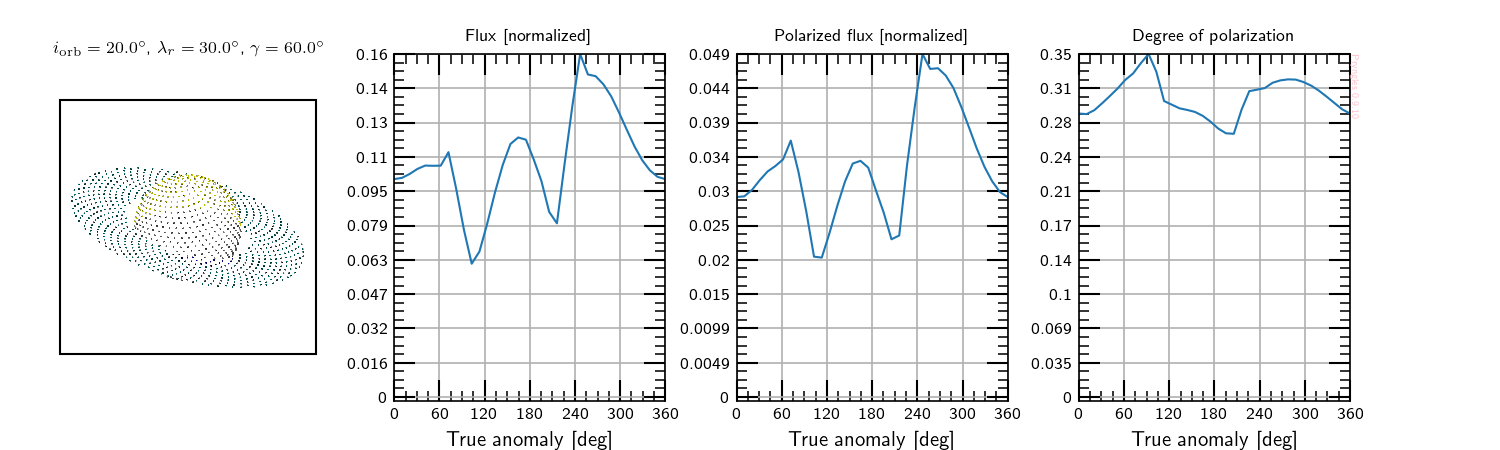

Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.05-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 9.908828020095825 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [42]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.nlambs = 36
ps_new.update_properties(quiet=False)
ps_new=polarimetry_exploration(ps_new,quiet=False)

The corresponding will be changing `br_0.00-omr_0.80`, `rl_0.00-ri_80.00` and `rin_2.00-rou_2.25`: 

Ring-less case:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e

100%|██████████| 36/36 [00:01<00:00, 28.41it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


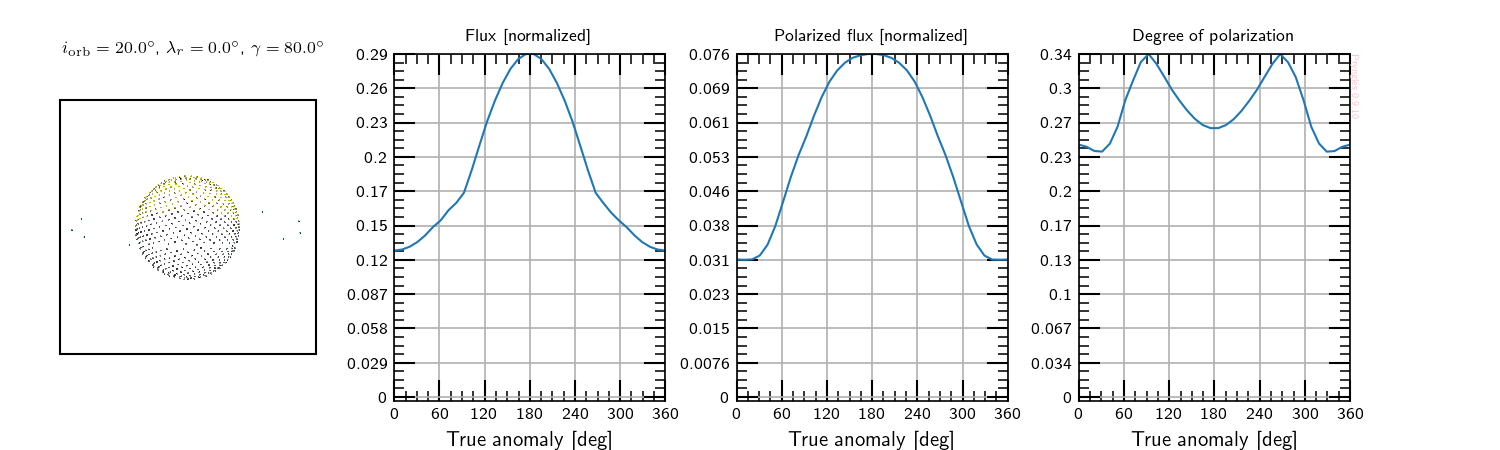

Saving figures/polarimetry-N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 7.228819131851196 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [43]:
ps_rl = deepcopy(ps_model)
ps_rl.progress=tqdm
ps_rl.Np = 1000
ps_rl.nlambs = 36
ps_rl.tau_ring = 0.0
ps_rl.omegar = 0.8
ps_rl.Nr = 30
ps_rl.lambr = 0.0
ps_rl.gamma = 80.0
ps_rl.ring_ri = 2.0
ps_rl.ring_re = 2.25
ps_rl.update_properties(quiet=False)
ps_rl=polarimetry_exploration(ps_rl,quiet=False)

Model set:

In [44]:
ps_set = []
for omegar in omegars:
    ps_new=deepcopy(ps_model)
    ps_new.progress=notqdm
    ps_new.Np = 1000
    ps_new.nlambs = 36
    ps_new.omegar = omegar
    ps_new.update_properties(quiet=True)
    ps_set += [ps_new]
print(f"Exploration set with {len(ps_set)} simulations")

Exploration set with 4 simulations


Run them in parallel:

In [45]:
# Other backends = 'threading', 'sequential', 'multiprocessing'
#backend = 'sequential';quiet = False
backend='loky';quiet = True
n_jobs = joblib.cpu_count()-2
tini=time.time()
joblib.Parallel(n_jobs=n_jobs,
                backend=backend,verbose=50)(joblib.delayed(polarimetry_exploration)(ps, quiet = quiet) for ps in ps_set)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done   2 out of   4 | elapsed:   12.4s remaining:   12.4s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:   12.5s finished
Parallel execution time = 12.511064052581787


Now we can plot them together:

<IPython.core.display.Javascript object>


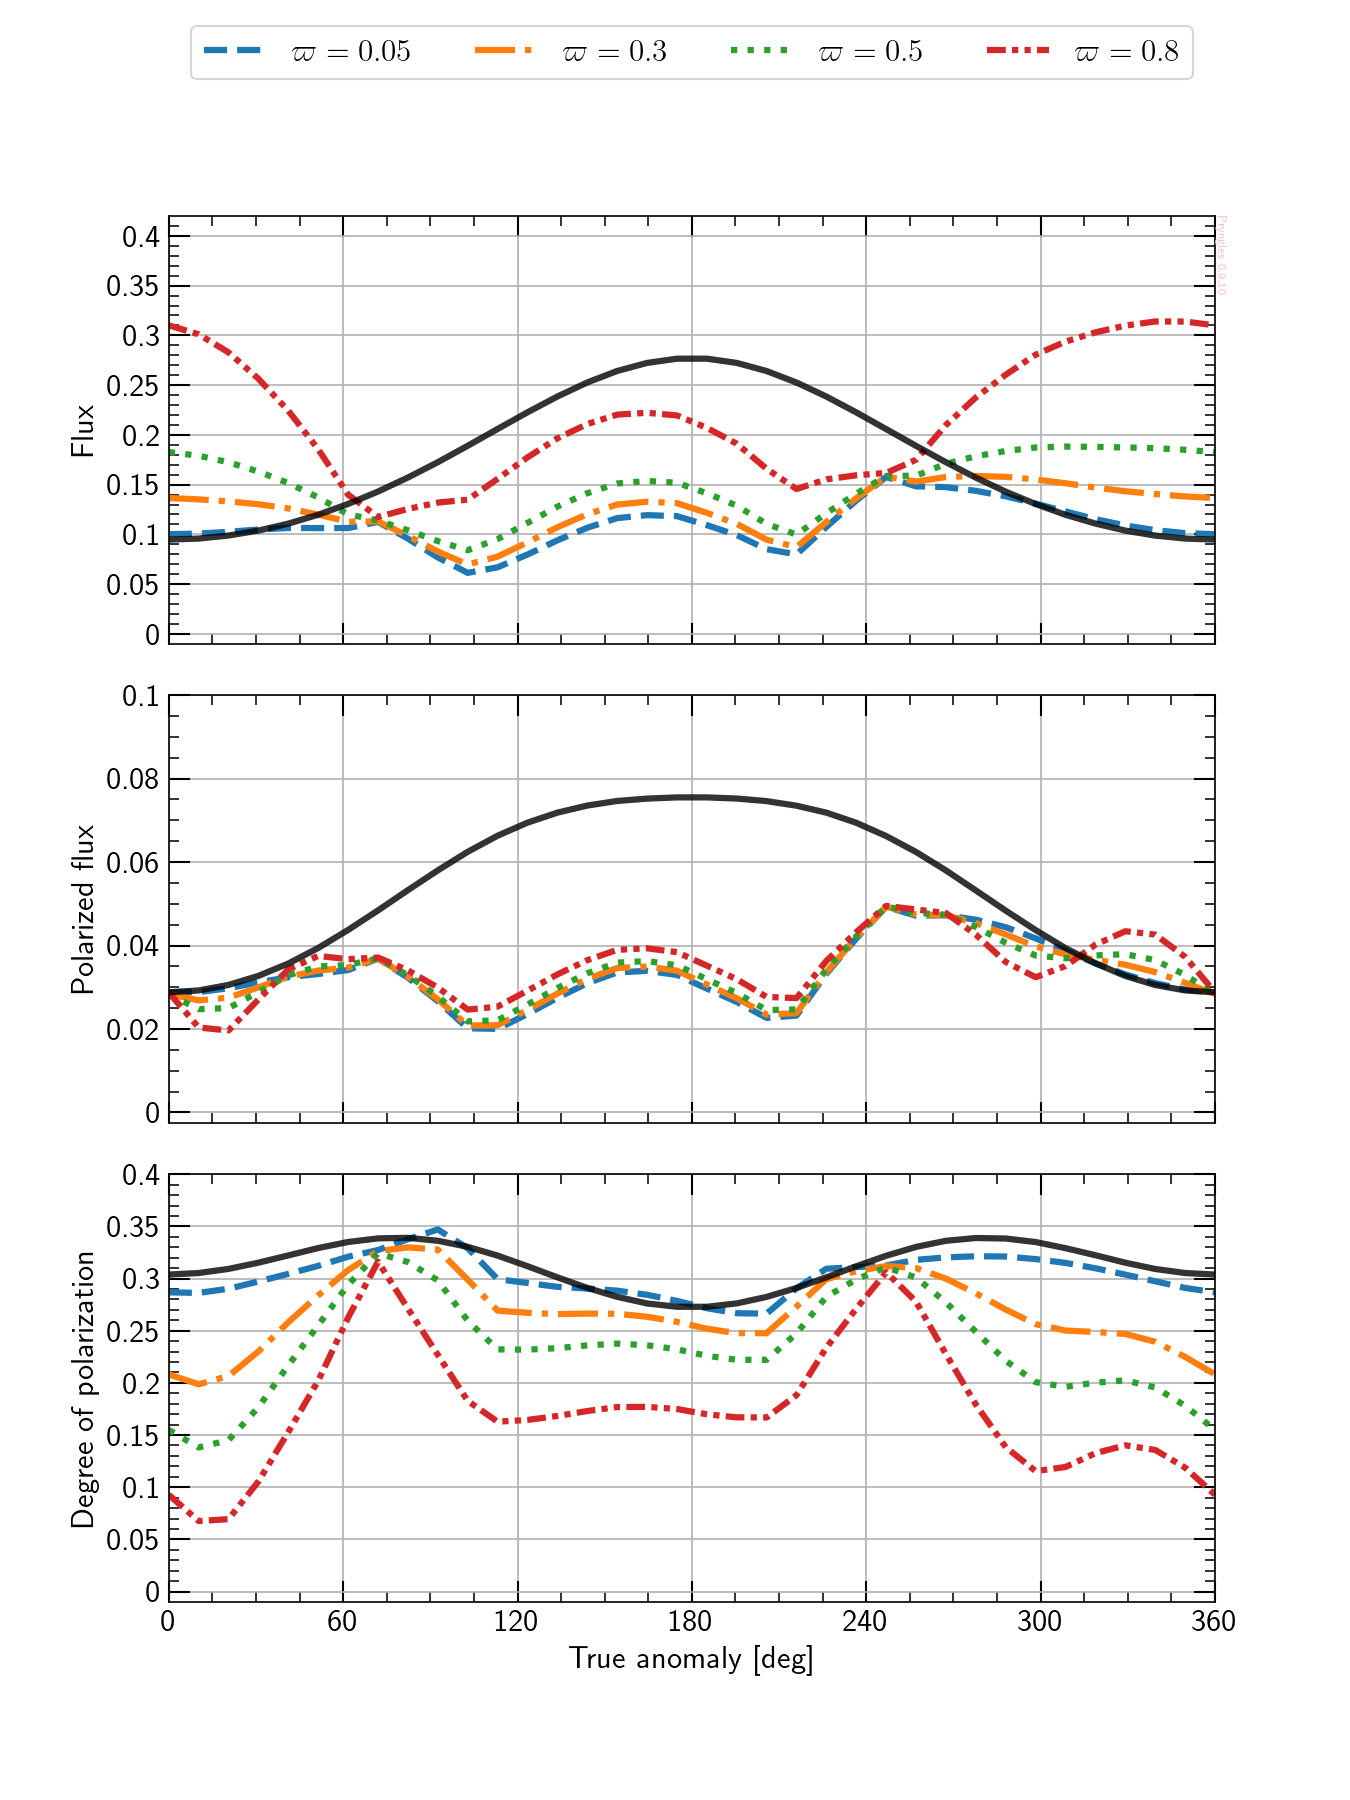

Saving figures/Particle_albedo_sweep.png...


In [46]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
nlines = len(plot_line)

ps=deepcopy(ps_model)
correct_order = np.array([0,1,2,3])
for i,omegar in enumerate(omegars[correct_order]):
    
    # Recovering data
    ps.omegar = omegar
    ps.update_properties(quiet = True)
    name = ps.get_name()
    data_name = tmp_dir + f"data_{name}.pkl"    
    with open(data_name,"rb") as f:
        data = pickle.load(f)
        ps = Parameters(**data)
    
    # Total flux
    axs[0].plot(ps.true_anomaly,ps.LC[:,1],linestyle=plot_line[i%n_lines],label=f"$\\varpi={ps.omegar}$",linewidth=3)
    axs[1].plot(ps.true_anomaly,ps.LC[:,2],linestyle=plot_line[i%n_lines],linewidth=3)
    axs[2].plot(ps.true_anomaly,abs(ps.LC[:,3]),linestyle=plot_line[i%n_lines],linewidth=3)

# Planetary flux
pname = ps.name
pname = re.sub('br_\d+\.\d+','br_0.00',pname)
pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
data_name = tmp_dir + f"data_{pname}.pkl"    
with open(data_name,"rb") as f:
    data = pickle.load(f)
    ps_rl = Parameters(**data)
Fluxp = ps_rl.LC[:,8]
Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
Pp = ps_rl.LC[:,14]
axs[0].plot(ps.true_anomaly,Fluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[1].plot(ps.true_anomaly,Pfluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[2].plot(ps.true_anomaly,abs(Pp),linestyle="-",color="k",linewidth=3,alpha=0.8)
                
# Decorate    
axs[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.48),ncol=4)
for ax in axs:
    ax.grid()

notext = False
setup_plot(axs[0],60,0,360,0.05,-0.01,0.42,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.05,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

prymark(axs[0])
save_figure(fig, "Particle_albedo_sweep", fig_dir=fig_dir, dpi=600)

### Experiment: varying ring size

Now we will vary the ring outer radius (`ring_re` or $r_{\rm out}$).

Prepare the model:

In [47]:
ps_model=Parameters(**dict(
    # Geometrical factors
    iorb = 20.0, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = 30.0, 
    gamma = 60.0, # Ring inclination, 90 degrees is edge-on orbit
    
    # Optical parameters
    tau_ring = 1.0, # Optical thickness of the ring
    omegar = 0.8, # Single scattering albedo of the ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of the planet surface

    # Planet and ring size
    Rs = Consts.rsun, # Stellar radius in m
    Rp = Consts.rsaturn, # Planet radius in m
    ring_ri = 1.2,
    ring_re = 5.0,

    # Orbital properties
    a = 1, # au
    e = 0, 

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 1000, # Number of spangles in ring
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
        
    # Normalization
    normalize = True,
    
    # If not normalized
    normfactor = 1e6,
    units = 'ppm'
))
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_5.00-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00


And test it:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_5.00-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_5.00-a_1.00

100%|██████████| 36/36 [00:01<00:00, 23.83it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


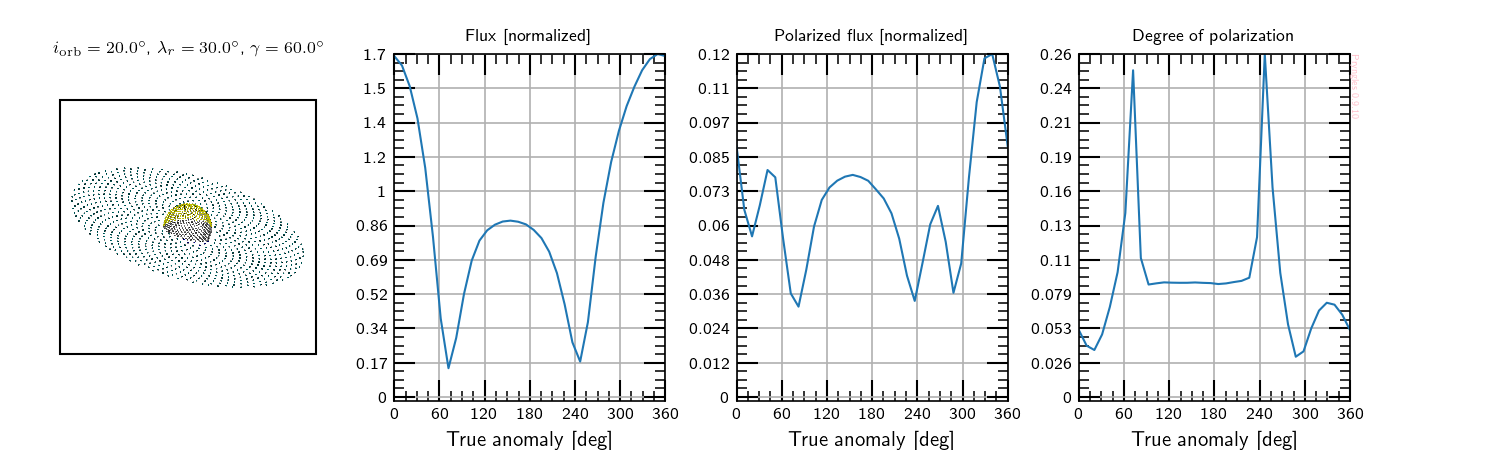

Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_5.00-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 8.43215823173523 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [48]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.nlambs = 36
ps_new.update_properties(quiet=False)
ps_new=polarimetry_exploration(ps_new,quiet=False)

Ring-less case:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e

100%|██████████| 36/36 [00:01<00:00, 27.75it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


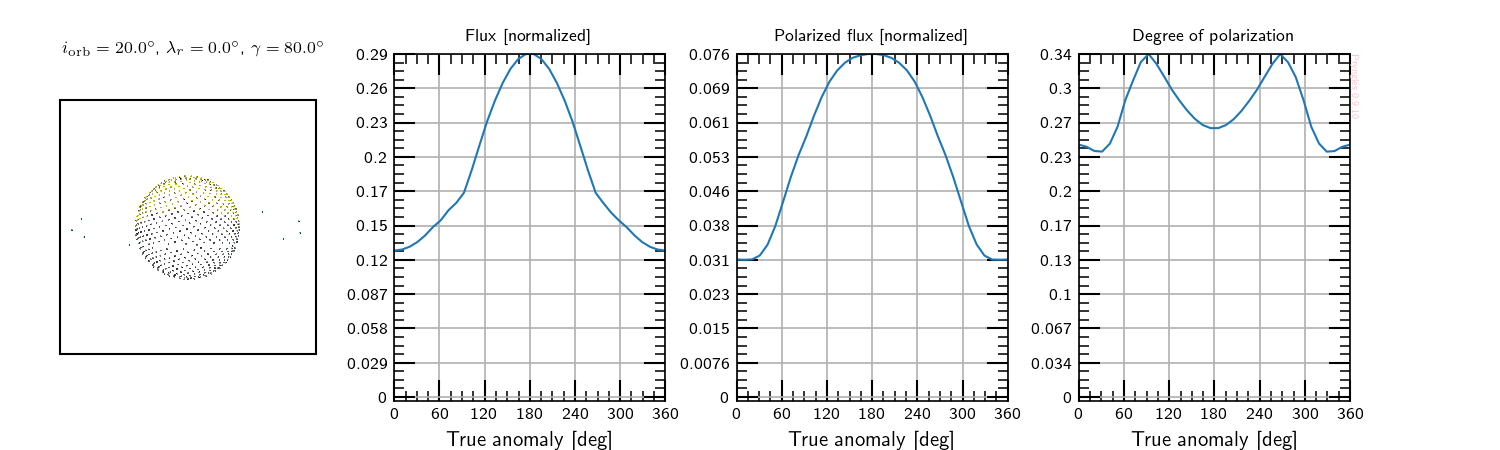

Saving figures/polarimetry-N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 7.145126819610596 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [49]:
ps_rl = deepcopy(ps_model)
ps_rl.progress=tqdm
ps_rl.Np = 1000
ps_rl.nlambs = 36
ps_rl.tau_ring = 0.0
ps_rl.omegar = 0.8
ps_rl.Nr = 30
ps_rl.lambr = 0.0
ps_rl.gamma = 80.0
ps_rl.ring_ri = 2.0
ps_rl.ring_re = 2.25
ps_rl.update_properties(quiet=False)
ps_rl=polarimetry_exploration(ps_rl,quiet=False)

Model set:

In [50]:
ps_set = []
ring_res = np.array([1.75,2.00,2.25,2.50,3.00,4.00,5.00])
for ring_re in ring_res:
    ps_new=deepcopy(ps_model)
    ps_new.progress=notqdm
    ps_new.Np = 1000
    ps_new.nlambs = 36
    ps_new.ring_re = ring_re
    ps_new.update_properties(quiet=True)
    ps_set += [ps_new]
print(f"Exploration set with {len(ps_set)} simulations")

Exploration set with 7 simulations


Run them in parallel:

In [51]:
# Other backends = 'threading', 'sequential', 'multiprocessing'
#backend = 'sequential';quiet = False
backend='loky';quiet = True
n_jobs = joblib.cpu_count()-2
tini=time.time()
joblib.Parallel(n_jobs=n_jobs,
                backend=backend,verbose=50)(joblib.delayed(polarimetry_exploration)(ps, quiet = quiet) for ps in ps_set)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done   2 out of   7 | elapsed:   11.9s remaining:   29.7s
[Parallel(n_jobs=6)]: Done   3 out of   7 | elapsed:   12.0s remaining:   16.0s
[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:   12.2s remaining:    9.1s
[Parallel(n_jobs=6)]: Done   5 out of   7 | elapsed:   12.2s remaining:    4.9s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:   19.7s finished
Parallel execution time = 19.678726196289062


Now we can plot them together:

<IPython.core.display.Javascript object>


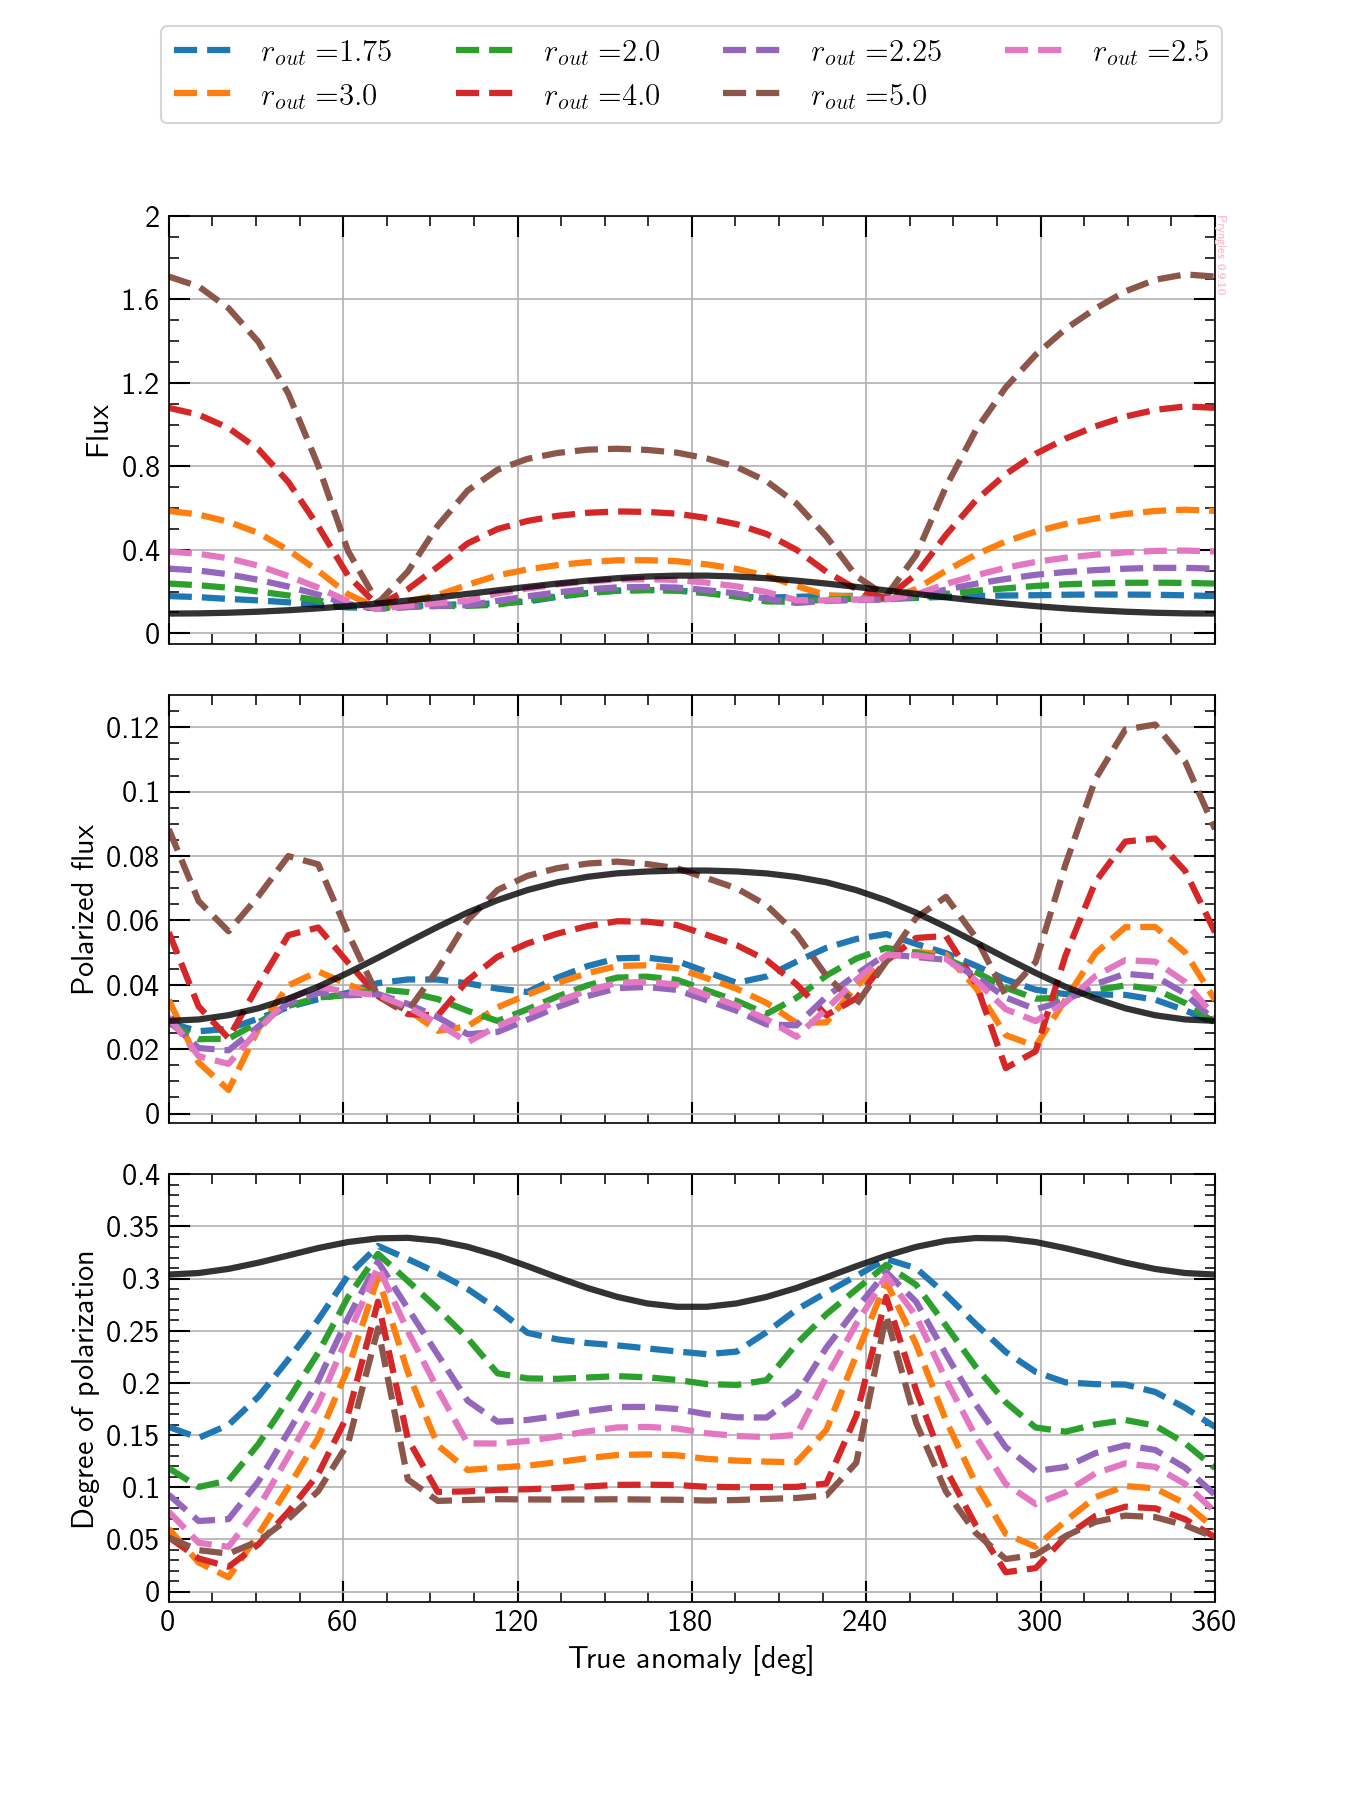

Saving figures/final/Ring_radius_sweep.png...


In [52]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
n_lines = len(plot_line)

ps=deepcopy(ps_model)
correct_order = np.array([0,4,1,5,2,6,3])
for i,ring_re in enumerate(ring_res[correct_order]):
    
    # Recovering data
    ps.ring_re = ring_re
    ps.update_properties(quiet = True)
    name = ps.get_name()
    data_name = tmp_dir + f"data_{name}.pkl"    
    with open(data_name,"rb") as f:
        data = pickle.load(f)
        ps = Parameters(**data)
    
    # Total flux
    axs[0].plot(ps.true_anomaly,ps.LC[:,1],linestyle='--',label="$r_{out}=$" + f"${ps.ring_re}$",linewidth=3)
    axs[1].plot(ps.true_anomaly,ps.LC[:,2],linestyle='--',linewidth=3)
    axs[2].plot(ps.true_anomaly,abs(ps.LC[:,3]),'--',linewidth=3)

# Planetary flux
pname = ps.name
pname = re.sub('br_\d+\.\d+','br_0.00',pname)
pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
data_name = tmp_dir + f"data_{pname}.pkl"    
with open(data_name,"rb") as f:
    data = pickle.load(f)
    ps_rl = Parameters(**data)
Fluxp = ps_rl.LC[:,8]
Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
Pp = ps_rl.LC[:,14]
axs[0].plot(ps.true_anomaly,Fluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[1].plot(ps.true_anomaly,Pfluxp,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[2].plot(ps.true_anomaly,abs(Pp),linestyle="-",color="k",linewidth=3,alpha=0.8)
                
# Decorate    
axs[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.48),ncol=4)
pr.Plot.pryngles_mark(axs[0])
for ax in axs:
    ax.grid()

notext = False
setup_plot(axs[0],60,0,360,0.4,-0.05,2.0,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0029,0.13,notext=notext)
setup_plot(axs[2],60,0,360,0.05,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

prymark(axs[0])
save_figure(fig, "Ring_radius_sweep", fig_dir=fig_final_dir, dpi=600)

### Experiment: Geometry dependence

In this experiment we want to study the dependence of the polarimetry light-curve on the orbital and ring inclination and orientation.

In [53]:
parameters=dict(
    # Geometrical factors
    iorb = 20.0, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = 30.0, 
    gamma = 60.0, # Ring inclination, 90 degrees is edge-on orbit

    # Optical parameters
    tau_ring = 1.0, # Optical thickness of the ring
    omegar = 0.8, # Single scattering albedo of the ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of the planet surface

    # Planet and ring size
    Rs = Consts.rsun, # Stellar radius in m
    Rp = Consts.rsaturn, # Planet radius in m
    ring_ri = 1.2,
    ring_re = 2.25,

    # Orbital properties
    a = 1, # au
    e = 0, 

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 1000, # Number of spangles in ring
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
    
    # Normalization
    normalize = True,

    # If not normalized
    normfactor = 1e6,
    units = 'ppm'
)
ps_model = Parameters(**parameters)
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00


As usual let's test it:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg
Model name: N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00
Running polarimetry simulation for N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00

100%|██████████| 36/36 [00:01<00:00, 18.46it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


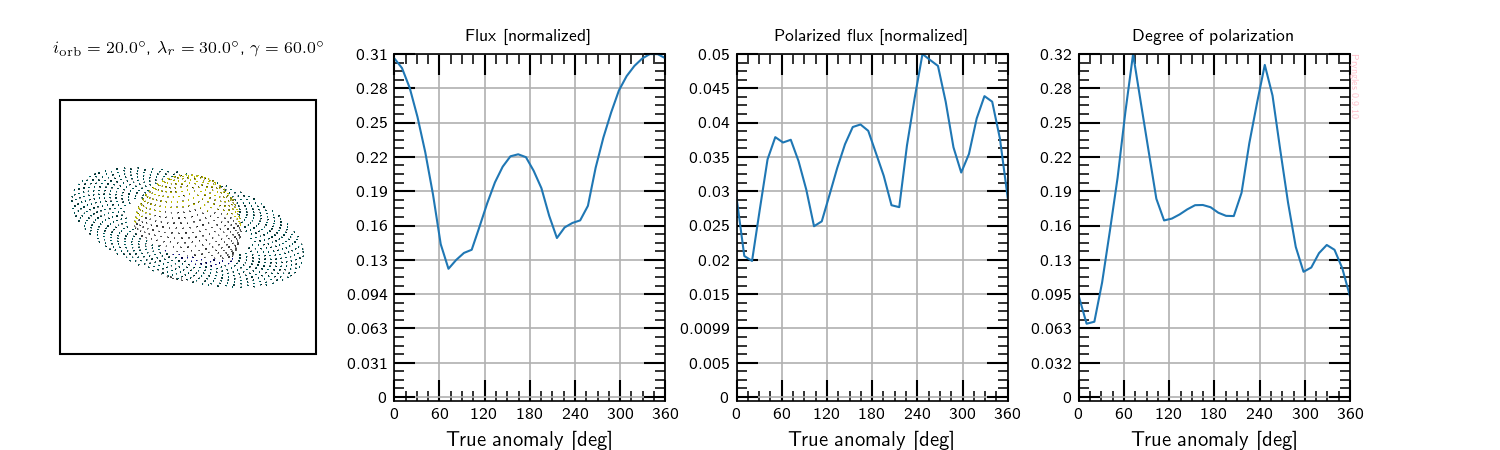

Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
	Running time: 8.483132123947144 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [54]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.nlambs = 36
ps_new.update_properties(quiet=False)
ps_new=polarimetry_exploration(ps_new,quiet=False)

Model set:

In [55]:
iorbs=[20.0,90.0]
lambrs=[0.0,30.0,60.0,90.0]
gammas=[0.0,30.0,60.0,90.0]
ps_set=[]
for iorb in iorbs:
    for gamma in gammas:
        for lambr in lambrs:
            ps_new=deepcopy(ps_model)
            ps_new.iorb=iorb
            ps_new.lambr=lambr
            ps_new.gamma=gamma
            ps_new.progress=notqdm
            ps_new.Np = 10000
            ps_new.Nr = 10000
            ps_new.nlambs = 361
            ps_new.update_properties(quiet=True)
            ps_set += [ps_new]

print(f"Exploration set with {len(ps_set)} simulations")

Exploration set with 32 simulations


Run in parallel:

In [56]:
# Other backends = 'threading', 'sequential', 'multiprocessing'
#backend = 'sequential';quiet = False
backend='loky';quiet = True
n_jobs = joblib.cpu_count()-2
tini=time.time()
joblib.Parallel(n_jobs=n_jobs,
                backend=backend,verbose=50)(joblib.delayed(polarimetry_exploration)(ps, quiet = quiet) for ps in ps_set)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  7.0min
[Parallel(

Now that we have the result for all the configurations explored we can plot it for the paper:

<IPython.core.display.Javascript object>


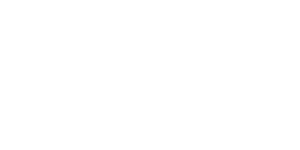

Saving figures/final/Geom_orbit_i_20_low.png...
Saving figures/final/Geom_orbit_i_20_low.svg...
Saving figures/final/Geom_orbit_i_20_low.eps...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


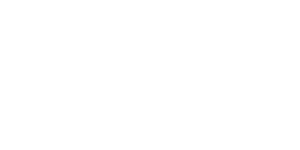

Saving figures/final/Geom_orbit_i_90_low.png...
Saving figures/final/Geom_orbit_i_90_low.svg...
Saving figures/final/Geom_orbit_i_90_low.eps...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [57]:
fsize = 7 # Use 1 for preview, 7 for original

# Parameter variations
iorbs = np.array([20.0,90.0]) # 20 or 90
gammas = np.array([0,30,60,90]) # 90 is edge-on, 0 is face-on
lambrs = np.array([0,30,60,90])

plot_line = [(0, (3, 1, 1, 1, 1, 1)),"--","-.",":"]
sub_plot_loc = [0.75,0.5,0.25,0.0]

plt.rcParams.update({'font.size': 20})
notext = True
for iorb in iorbs:

    plt.rcParams.update({'font.size': int(3.5*fsize)})
    fig = plt.figure(figsize=(5*fsize,5*fsize))
    gs = fig.add_gridspec(ncols=4, nrows=4, hspace=0.12, width_ratios= [0.5,1,1,1])
    axs = gs.subplots(sharex=True)

    for j,lambr in enumerate(lambrs):
        for k,gamma in enumerate(gammas):

            ps = deepcopy(ps_model)
            ps.iorb = iorb
            ps.lambr = lambr
            ps.gamma = gamma
            data_name = tmp_dir + f"data_{ps.get_name()}.pkl"
            figure_loc = fig_dir + f"config-{ps.get_name()}-obs.png"

            with open(data_name,"rb") as f:
                data = pickle.load(f)
            ps = Parameters(**data)

            # Insert figure
            subpos = [0.0,sub_plot_loc[k],0.5,0.25]
            subax1 = add_subplot_axes(axs[j,0],subpos)
            figure = cv.imread(figure_loc)
            b, g, r = cv.split(figure)
            tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
            tmp,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
            rgba = [r,g,b,alp]
            figure = cv.merge(rgba,4)
            scale_percent = 80
            width = int(figure.shape[1] * scale_percent / 100)
            height = int(figure.shape[0] * scale_percent / 100)
            dim = (width,height)
            resized = cv.resize(figure, dim, interpolation = cv.INTER_AREA)
            subax1.imshow(resized, interpolation='bicubic', aspect='auto')
            if k==0:
                subax1.text(0.0, 1.15, f'$\lambda_r = {lambr}^\circ$',
                            {'fontsize': 3.5*fsize}, horizontalalignment='left',
                            verticalalignment='center', transform=subax1.transAxes)
            subax1.text(1.3, 0.5, f'$\gamma = {gamma}^\circ$', {'fontsize': 3.5*fsize},
                        horizontalalignment='left', verticalalignment='center', 
                        transform=subax1.transAxes)
            subax1.set_axis_off()
            axs[j,0].set_axis_off()

            # Plot data
            axs[j,1].plot(ps.true_anomaly,ps.LC[:,1],
                           linestyle=plot_line[k],label=f"{ps.gamma}$^\circ$",linewidth=0.4*fsize)
            axs[j,2].plot(ps.true_anomaly,ps.LC[:,2],
                           linestyle=plot_line[k],label=f"Inclination {ps.gamma}",linewidth=0.4*fsize)
            axs[j,3].plot(ps.true_anomaly,abs(ps.LC[:,3]),
                           linestyle=plot_line[k],label=f"Inclination {ps.gamma}",linewidth=0.4*fsize)
            axs[j,1].legend()

            # Plot planet
            if k == 0:
                pname = ps.name
                pname = re.sub('br_.*-bp','br_0.00-omr_0.80-bp',pname)
                pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
                pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
                data_name = tmp_dir + f"data_{pname}.pkl"    
                with open(data_name,"rb") as f:
                    data = pickle.load(f)
                    ps_rl = Parameters(**data)
                Fluxp = ps_rl.LC[:,8]
                Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
                Pp = ps_rl.LC[:,14]

                axs[j,1].plot(ps_rl.true_anomaly,Fluxp,
                              linestyle="-",color="k",linewidth=0.4*fsize)
                axs[j,2].plot(ps_rl.true_anomaly,Pfluxp,
                              linestyle="-",color="k",linewidth=0.4*fsize)
                axs[j,3].plot(ps_rl.true_anomaly,abs(Pp),
                              linestyle="-",color="k",linewidth=0.4*fsize)

            # Setup plot
            if iorb == 20:
                setup_plot(axs[j,1],60,0,360,0.05,-0.01,0.42,notext=notext)
                setup_plot(axs[j,2],60,0,360,0.02,-0.0025,0.1,notext=notext)
                setup_plot(axs[j,3],60,0,360,0.05,-0.01,0.4,notext=notext)
            else:
                setup_plot(axs[j,1],60,0,360,0.2,-0.025,1.02,notext=notext)
                setup_plot(axs[j,2],60,0,360,0.02,-0.0025,0.1,notext=notext)
                setup_plot(axs[j,3],60,0,360,0.05,-0.01,0.4,notext=notext)


    axs[0,1].set_title("Flux",fontsize=5*fsize)
    axs[0,2].set_title("Polarized flux",fontsize=5*fsize)
    axs[0,3].set_title("Degree of polarization",fontsize=5*fsize)
    [axs[3,n].set_xlabel("True anomaly [deg]",fontsize=5*fsize) for n in [1,2,3]]

    for j in range(len(lambrs)):
        [axs[j,n].grid() for n in [1,2,3]]

    save_figure(fig,f"Geom_orbit_i_{iorb:.0f}_low", fig_dir=fig_final_dir, dpi=600, formats=['png','svg','eps'])

## Real case: HIP 41378 f

In this experiment, we will explore the case of a real planet, the *puffed* jupiter HIP 41378 f. According to the following paper the transit light-curve can be fitted as if the planet has an opaque dusty ring almost face on with inclination and orientation parameters given by:

In [58]:
i = -25  # 
phi = 95

In the firt place we need to express this orientation using the proper angles in our conventions. We have designed for this purpose the `convert_normal_vectors` we include at the beginning of this Notebook:

In [59]:
gamma,lambr,fun = convert_normal_vectors(i,180-phi)
print(f"Ring inclination and roll angles in the plane of the sky: {gamma} deg, {lambr} deg")

Ring inclination and roll angles in the plane of the sky: -2.110887807079195 deg, -24.91643379350276 deg


As usual we need a reference model for this planet. Here we use the stellar, planetary and ring parameters as provided by the reference paper:

In [60]:
ps_model=Parameters(**dict(
    
    # Geometrical factors
    iorb = 89.97, # Orbital inclination, 90 degrees is edge-on orbit
    lambr = lambr, 
    gamma = gamma, # Ring inclination, 90 degrees is edge-on orbit

    # Optical parameters
    tau_ring = 4.0, # Optical thickness of the ring
    omegar = 0.8, # Single scattering albedo of the ring particles
    bp = 10.0, # Optical thickness of the planet atmosphere
    omegap = 0.5, # Albedo of the planet surface

    # Planet and ring size
    Rs = 1.273*Consts.rsun, # Stellar radius in m
    Rp = 3.7*Consts.rearth, # Planet radius in m
    ring_ri = 1.05,
    ring_re = 2.6,

    # Orbital properties
    a = 231*1.273*Consts.rsun/Consts.au, # au
    e = 0,

    # Number of spangles
    Np = 1000, # Number of spangles in planet
    Nr = 1000, # Number of spangles in ring
    Ns = 30,
    Nb = 0,
    
    # Longitudes to explore
    nlambs = 36,
    delta_lamb = 360,
    
    # Progress bar for the light-curve calculation
    progress = tqdm,
    
    # Optional parameters
    normalize = False,
    
    # If not normalized
    normfactor = 1e9,
    units = 'ppb'
))
ps_model.update_properties(quiet = False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_4_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_4_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_4_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 92.1 deg
	Inclination of the observer w.r.t ecliptic: 0.0 deg
	Initial longitude of the observer: 114.9 deg
	Initial longitude of the star: -65.1 deg
Model name: N_0.00-io_89.97-rl_-24.92-ri_-2.11-br_4.00-omr_0.80-bp_10.00-omp_0.50-rin_1.05-rou_2.60-a_1.37-e_0.00-Rs_885626100.00-Rp_23599106.90


As usual, let's test it:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_4_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_4_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_4_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 92.1 deg
	Inclination of the observer w.r.t ecliptic: 0.0 deg
	Initial longitude of the observer: 114.9 deg
	Initial longitude of the star: -65.1 deg
Model name: N_0.00-io_89.97-rl_-24.92-ri_-2.11-br_4.00-omr_0.80-bp_10.00-omp_0.50-rin_1.05-rou_2.60-a_1.37-e_0.00-Rs_885626100.00-Rp_23599106.90
Running polarimetry simulation for N_0.00-io_89.97-rl_-24.92-ri_-2.11-br_4.00-omr_0.80-bp_10.00-omp_0.50-rin_1.05-rou_2.60-a_1.3

100%|██████████| 36/36 [00:01<00:00, 25.30it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


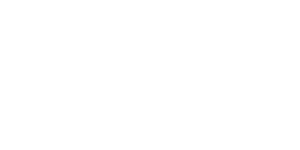

Saving figures/polarimetry-N_0.00-io_89.97-rl_-24.92-ri_-2.11-br_4.00-omr_0.80-bp_10.00-omp_0.50-rin_1.05-rou_2.60-a_1.37-e_0.00-Rs_885626100.00-Rp_23599106.90.png...
	Running time: 7.931679964065552 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [61]:
ps_new = deepcopy(ps_model)
ps_new.progress=tqdm
ps_new.Np = 1000
ps_new.nlambs = 36
ps_new.update_properties(quiet=False)
ps_new=polarimetry_exploration(ps_new,quiet=False)

For the ring-less case we have two options:

1. The ring-less planet. This planet has the same parameters as before.
1. The puffed planet (no ring). In this case we need to modify several parameters, the radius of the planet and the orbital semimajor axis.

Let's compute first the ring-less

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 10.0 deg
	Inclination of the observer w.r.t ecliptic: 0.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_0.00-io_89.97-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.37-e_0.00-Rs_885626100.00-Rp_23599106.90
Running polarimetry simulation for N_0.00-io_89.97-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.37-e_0

100%|██████████| 36/36 [00:01<00:00, 22.00it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


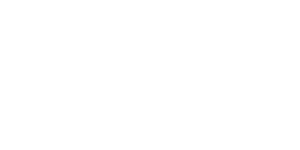

Saving figures/polarimetry-N_0.00-io_89.97-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.37-e_0.00-Rs_885626100.00-Rp_23599106.90.png...
	Running time: 7.929558038711548 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [62]:
ps_rl = deepcopy(ps_model)
ps_rl.progress=tqdm
ps_rl.Np = 1000
ps_rl.nlambs = 36
ps_rl.tau_ring = 0.0
ps_rl.omegar = 0.8
ps_rl.Nr = 30
ps_rl.lambr = 0.0
ps_rl.gamma = 80.0
ps_rl.ring_ri = 2.0
ps_rl.ring_re = 2.25
ps_rl.update_properties(quiet=False)
ps_rl=polarimetry_exploration(ps_rl,quiet=False)

And the puffed planet is:

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_bmsca10.0_asurf0.5.dat', 'tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 10.0 deg
	Inclination of the observer w.r.t ecliptic: 0.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg
Model name: N_0.00-io_89.97-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.37-e_0.00-Rs_885626100.00-Rp_58742641.77
Running polarimetry simulation for N_0.00-io_89.97-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.37-e_0

100%|██████████| 36/36 [00:01<00:00, 30.04it/s]

	Plotting light curves...


<IPython.core.display.Javascript object>


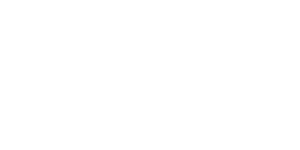

Saving figures/polarimetry-N_0.00-io_89.97-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.37-e_0.00-Rs_885626100.00-Rp_58742641.77.png...
	Running time: 7.588222980499268 seconds
	Pickling result...
		Pickling variables: dict_keys(['iorb', 'lambr', 'gamma', 'tau_ring', 'omegar', 'bp', 'omegap', 'Rs', 'Rp', 'ring_ri', 'ring_re', 'a', 'e', 'Np', 'Nr', 'Ns', 'Nb', 'nlambs', 'delta_lamb', 'normalize', 'normfactor', 'units', 'ir', 'beta_obs', 'lamb_obs', 'lamb_star', 'fou_file_planet', 'fou_file_ring', 'name', 'lamb_initial', 'lamb_final', 'lambs', 'LC', 'LC_normalized', 'true_anomaly'])...
		Avoiding to pickle variables: dict_keys(['progress'])...


In [63]:
ps_pf = deepcopy(ps_model)
ps_pf.progress=tqdm
ps_pf.Np = 1000
ps_pf.nlambs = 36
ps_pf.tau_ring = 0.0
ps_pf.omegar = 0.8
ps_pf.Nr = 30
ps_pf.lambr = 0.0
ps_pf.gamma = 80.0
ps_pf.ring_ri = 2.0
ps_pf.ring_re = 2.25
ps_pf.a = 231.6*1.273*Consts.rsun/Consts.au
ps_pf.Rp = 9.21*Consts.rearth
ps_pf.update_properties(quiet=False)
ps_pf=polarimetry_exploration(ps_pf,quiet=False)

First we need the Fourier coefficients files:

In [64]:
tau_rings = np.array([4.0,20.0])
omegars = np.array([0.05,0.8])

for tau_ring in tau_rings:
    for omegar in omegars:
        br = tau_ring if tau_ring > 0 else 0
        fou_file_ring = f'fou_ring_{str(br).replace(".","_")}_{str(omegar).replace(".","_")}.dat'
        pr.Misc.retrieve_data([fou_file_ring],path=tmp_dir, overwrite=False, quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_4_0_0_05.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_4_0_0_05.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_4_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_4_0_0_8.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_20_0_0_05.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_20_0_0_05.dat']
Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_20_0_0_8.dat already retrieved. F

Model set:

In [65]:
ps_set = []

#Varying parameters
for tau_ring in tau_rings:
    for omegar in omegars:
        ps_new=deepcopy(ps_model)
        ps_new.progress=notqdm
        ps_new.Np = 1000
        ps_new.nlambs = 36
        ps_new.tau_ring = tau_ring
        ps_new.omegar = omegar
        ps_new.update_properties(quiet=True)
        ps_set += [ps_new]

print(f"Exploration set with {len(ps_set)} simulations")

Exploration set with 4 simulations


Run them in parallel:

In [66]:
# Other backends = 'threading', 'sequential', 'multiprocessing'
#backend = 'sequential';quiet = False
backend='loky';quiet = True
n_jobs = joblib.cpu_count()-2
tini=time.time()
joblib.Parallel(n_jobs=n_jobs,
                backend=backend,verbose=50)(joblib.delayed(polarimetry_exploration)(ps, quiet = quiet) for ps in ps_set)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done   2 out of   4 | elapsed:   10.8s remaining:   10.8s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:   17.6s finished
Parallel execution time = 17.61565589904785


Now we need to plot everything together:

<IPython.core.display.Javascript object>


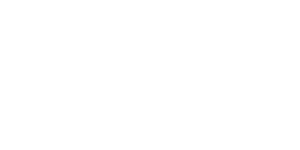

Saving figures/final/HIP41378f_albedo_and_tau_sweep_planet_only.png...


In [67]:
plt.rcParams.update({'font.size': 15})

normfactor = 1e9
units = 'ppb'

fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
n_lines = len(plot_line)

ps=deepcopy(ps_model)
i = 0
for omegar in omegars:
    for tau_ring in tau_rings:

        # Recovering data
        ps.omegar = omegar
        ps.tau_ring = tau_ring
        ps.update_properties(quiet = True)
        name = ps.get_name()
        data_name = tmp_dir + f"data_{name}.pkl"
        
        with open(data_name,"rb") as f:
            data = pickle.load(f)
            ps = Parameters(**data)

        # Total flux
        axs[0].plot(ps.true_anomaly,ps.LC[:,1]*normfactor,linestyle=plot_line[i%n_lines],
                    label=f"$\\varpi = {omegar}$, $b={tau_ring}$",linewidth=3)
        axs[1].plot(ps.true_anomaly,ps.LC[:,2]*normfactor,linestyle=plot_line[i%n_lines],linewidth=3)
        axs[2].plot(ps.true_anomaly,abs(ps.LC[:,3]),linestyle=plot_line[i%n_lines],linewidth=3)
        
        i+=1
        
Fmax=ps.LC[:,1].max()*normfactor
PFmax=ps.LC[:,2].max()*normfactor
Pmax=abs(ps.LC[:,3]).max()

# Planetary flux
pname = ps.name
pname = re.sub('br_.*-bp','br_0.00-omr_0.80-bp',pname)
pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
data_name = tmp_dir + f"data_{pname}.pkl"    
with open(data_name,"rb") as f:
    data = pickle.load(f)
    ps_rl = Parameters(**data)
Fluxp = ps_rl.LC[:,8]
Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
Pp = ps_rl.LC[:,14]
axs[0].plot(ps.true_anomaly,Fluxp*normfactor,linestyle="-",color="k",label="Ring model",linewidth=3,alpha=0.8)
axs[1].plot(ps.true_anomaly,Pfluxp*normfactor,linestyle="-",color="k",linewidth=3,alpha=0.8)
axs[2].plot(ps.true_anomaly,abs(Pp),linestyle="-",color="k",linewidth=3,alpha=0.8)

Fmax=max(Fmax,Fluxp.max()*normfactor)
PFmax=max(PFmax,Pfluxp.max()*normfactor)
Pmax=max(Pmax,Pp.max())

# Puffed-up planetary flux
pname = ps.name
pname = re.sub('br_.*-bp','br_0.00-omr_0.80-bp',pname)
pname = re.sub('rin_.*-a','rin_2.00-rou_2.25-a',pname)
pname = re.sub('rl_.*-br','rl_0.00-ri_80.00-br',pname)
pname = re.sub('Rp_.*','Rp_58742641.77',pname)
data_name = tmp_dir + f"data_{pname}.pkl"    
with open(data_name,"rb") as f:
    data = pickle.load(f)
    ps_rl = Parameters(**data)
Fluxp = ps_rl.LC[:,8]
Pfluxp = (ps_rl.LC[:,9]**2+ps_rl.LC[:,10]**2)**0.5
Pp = ps_rl.LC[:,14]
axs[0].plot(ps.true_anomaly,Fluxp*normfactor,linestyle="-",color="m",label="Planet-only model",linewidth=3,alpha=0.8)
axs[1].plot(ps.true_anomaly,Pfluxp*normfactor,linestyle="-",color="m",linewidth=3,alpha=0.8)
axs[2].plot(ps.true_anomaly,abs(Pp),linestyle="-",color="m",linewidth=3,alpha=0.8)

Fmax=max(Fmax,Fluxp.max()*normfactor)
PFmax=max(PFmax,Pfluxp.max()*normfactor)
Pmax=max(Pmax,Pp.max())

# Decorate    
axs[0].legend(loc='upper center',bbox_to_anchor=(0.5,1.4),ncol=2)
for ax in axs:
    ax.grid()

notext = False
setup_plot(axs[0],60,0,360,Fmax/10,-Fmax/100,Fmax,notext=notext)
setup_plot(axs[1],60,0,360,PFmax/10,-PFmax/100,PFmax,notext=notext)
setup_plot(axs[2],60,0,360,Pmax/10,-Pmax/100,Pmax,notext=notext)

axs[0].set_ylabel(f"Flux [{units}]")
axs[1].set_ylabel(f"Polarized flux [{units}]")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

pr.Plot.pryngles_mark(axs[0])

save_figure(fig, "HIP41378f_albedo_and_tau_sweep_planet_only", fig_dir=fig_final_dir, dpi=600)

## Additional plots

### Phase functions

First we need the scattering matrices required:

In [68]:
files=["s5.sc.F.dat", "20mu_4500_1.5.dat","40mu_4500_1.5.dat"]
pr.Misc.retrieve_data(files,path=tmp_dir,overwrite=False,quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//s5.sc.F.dat already retrieved. For overwrite use overwrite = True.
File tmp//20mu_4500_1.5.dat already retrieved. For overwrite use overwrite = True.
File tmp//40mu_4500_1.5.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//s5.sc.F.dat', 'tmp//20mu_4500_1.5.dat', 'tmp//40mu_4500_1.5.dat']


['tmp//s5.sc.F.dat', 'tmp//20mu_4500_1.5.dat', 'tmp//40mu_4500_1.5.dat']

Now we will plot the phase functions contained in the matrices:

<IPython.core.display.Javascript object>


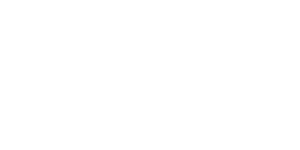

Saving figures/single_scattering_incl_mie20_and_40.png...


In [69]:
def rayleigh_phase_function(alpha,sigma):
    """Rayleigh phase function.
    """
    delta  = (1-sigma)/(1+sigma/2)
    deltal = (1-2*sigma)/(1-sigma)
    F11 = delta*(3/4)*(1+np.cos(alpha)**2)+(1-delta)
    P = np.sin(alpha)**2/(1+np.cos(alpha)**2 + 2*sigma/(1-sigma))
    return F11,P

names = ["s5.sc.F.dat", "20mu_4500_1.5.dat","40mu_4500_1.5.dat"]
plot_names = np.array(["Olivine particles", "Mie $20 \mu m$", "Mie $40 \mu m$"])

fsize=2
fig = plt.figure(figsize=(5*fsize,10*fsize))
gs = fig.add_gridspec(2,1, hspace=0.12)
ax = gs.subplots(sharex=False)
plt.rcParams.update({'font.size': 10*fsize})

for ii,name in enumerate(names):
    scattering_matrix_name = tmp_dir + name
    angle = []
    F11   = []
    F22   = []
    F33   = []
    F44   = []
    F12   = []
    F34   = []
    POL   = []

    for line in open(scattering_matrix_name).readlines():
        sp = line.split()
        angle += [float(sp[0])]
        F11   += [float(sp[1])]
        F22   += [float(sp[2])]
        F33   += [float(sp[3])]
        F44   += [float(sp[4])]
        F12   += [float(sp[5])]
        F34   += [float(sp[6])]
        POL   += [float(sp[7])]

    df = pd.DataFrame({"Angle": angle, "F11": F11, "F22": F22, "F33": F33,
                       "F44": F44, "F12": F12, "F34": F34, "POL": POL})

    ax[0].plot(df["Angle"], df["F11"],label=plot_names[ii])
    ax[1].plot(df["Angle"], df["POL"], label=plot_names[ii])

# Gas particles phase function
theta = np.linspace(0,np.pi,10000)
sigma = 0.02
F11,P = rayleigh_phase_function(theta,sigma)
ax[0].plot(theta*180/np.pi,F11,"--",label="Molecules")
ax[1].plot(theta*180/np.pi,P,"--",label="Molecules")

ax[0].set_ylabel("Phase function")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(30))
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].set_xlim([0,180])
setup_plot(ax[1],30,0,180,0.2,-0.4,1.0,notext=False)
ax[0].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[0].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

ax[1].set_ylabel("Degree of Polarization")
ax[1].set_xlabel("Scattering angle $\\theta$ [deg]")
ax[1].grid()
ax[1].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[1].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

save_figure(fig,"single_scattering_incl_mie20_and_40",fig_dir,dpi=600)

Only two of them:

<IPython.core.display.Javascript object>


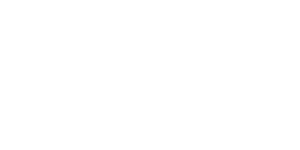

Saving figures/final/single_scattering.png...
Saving figures/final/single_scattering.svg...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving figures/final/single_scattering.eps...


In [70]:
names = ["s5.sc.F.dat"]
plot_names = np.array(["Particles"])

fsize=2
fig = plt.figure(figsize=(5*fsize,10*fsize))
gs = fig.add_gridspec(2,1, hspace=0.12)
ax = gs.subplots(sharex=False)
plt.rcParams.update({'font.size': 10*fsize})

for ii,name in enumerate(names):
    scattering_matrix_name = tmp_dir + name
    angle = []
    F11   = []
    F22   = []
    F33   = []
    F44   = []
    F12   = []
    F34   = []
    POL   = []

    for line in open(scattering_matrix_name).readlines():
        sp = line.split()
        angle += [float(sp[0])]
        F11   += [float(sp[1])]
        F22   += [float(sp[2])]
        F33   += [float(sp[3])]
        F44   += [float(sp[4])]
        F12   += [float(sp[5])]
        F34   += [float(sp[6])]
        POL   += [float(sp[7])]

    df = pd.DataFrame({"Angle": angle, "F11": F11, "F22": F22, "F33": F33,
                       "F44": F44, "F12": F12, "F34": F34, "POL": POL})

    ax[0].plot(df["Angle"], df["F11"],label=plot_names[ii])
    ax[1].plot(df["Angle"], df["POL"], label=plot_names[ii])

# Gas particles phase function
theta = np.linspace(0,np.pi,10000)
sigma = 0.02
F11,P = rayleigh_phase_function(theta,sigma)
ax[0].plot(theta*180/np.pi,F11,"--",label="Molecules")
ax[1].plot(theta*180/np.pi,P,"--",label="Molecules")

ax[0].set_ylabel("Phase function")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(30))
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].set_xlim([0,180])
setup_plot(ax[1],30,0,180,0.2,-0.4,1.0,notext=False)
ax[0].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[0].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

ax[1].set_ylabel("Degree of Polarization")
ax[1].set_xlabel("Scattering angle $\\theta$ [deg]")
ax[1].grid()
ax[1].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[1].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

save_figure(fig,"single_scattering",fig_final_dir, dpi=600, formats=['png','svg','eps'])

### Experiment: reflected flux

Here we will study the effect of optical thickness on the scattered light by ring particles.

Basic ring particle properties and corresponding fourier file coefficient:

In [71]:
tau_ring = 1.0
omegar = 0.8
fou_file_ring = f'fou_ring_{str(tau_ring).replace(".","_")}_{str(omegar).replace(".","_")}.dat'
pr.Misc.retrieve_data([fou_file_ring],path=tmp_dir,overwrite=False,quiet=False)
print(f"Fourier coefficients files required: {[fou_file_ring]}")

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_ring_1_0_0_8.dat']


Now we will load the Fourier coefficients file:

In [72]:
SCr=pr.StokesScatterer(tmp_dir + fou_file_ring)

Let's calculate the Stokes vector of a particular set of angles:

In [73]:
phidiffs = np.array([0.0*Consts.deg])
betas = np.array([0.0])
teta0s = np.array([0.0])
tetas = np.array([0.0])
etas = np.cos(teta0s)
zetas = np.cos(tetas)
afs = np.array([1.0])
qreflection = 1
SCr.calculate_stokes(phidiffs,betas,abs(etas),abs(zetas),afs,qreflection)

array([[0.05351844, 0.        , 0.        , 0.        ]])

Let's see how the reflected light depend on the illumination angle:

We first need to download all the data files for our exploration:

In [74]:
tau_rings = np.array([0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.4,0.6,0.8,
                     1.0,1.2,1.4,1.6,1.8,2.0,4.0,6.0,8.0,10.0,20.0])

size = 0
SCr=dict()
for tau_ring in tau_rings:
    print(f"Tau ring = {tau_ring}")
    fou_file_ring = f'fou_ring_{str(tau_ring).replace(".","_")}_{str(omegar).replace(".","_")}.dat'
    print(f"\tGetting the Fourier coefficients file {fou_file_ring}...")
    pr.Misc.retrieve_data([fou_file_ring],path=tmp_dir,overwrite=False,quiet=True)
    print(f"\tReading the the Fourier coefficients matrix...")
    SCr[fou_file_ring]=pr.StokesScatterer(tmp_dir + fou_file_ring)
    """ # Only works in the newest versions of python
    size += sys.getsizeof(SCr[fou_file_ring].rfou)
    print(f"\tAccumulated size = {size/1e6:.1f} Mb")
    """

Tau ring = 0.001
	Getting the Fourier coefficients file fou_ring_0_001_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.002
	Getting the Fourier coefficients file fou_ring_0_002_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.005
	Getting the Fourier coefficients file fou_ring_0_005_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.01
	Getting the Fourier coefficients file fou_ring_0_01_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.02
	Getting the Fourier coefficients file fou_ring_0_02_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.05
	Getting the Fourier coefficients file fou_ring_0_05_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.1
	Getting the Fourier coefficients file fou_ring_0_1_0_8.dat...
	Reading the the Fourier coefficients matrix...
Tau ring = 0.2
	Getting the Fourier coefficients file fou_ring_0_2_0_8.dat...
	Reading the the Fouri

Let's study for instance the pendence on `tau_ring` of the total flux when $\theta=\theta_0=0$:

In [75]:
teta0s = np.arange(0,90,10)*Consts.deg
phidiffs = 90.0*np.ones_like(teta0s)
betas = 0.0*np.ones_like(teta0s)
tetas = 0.0*np.ones_like(teta0s)
etas = np.cos(teta0s)
zetas = np.cos(tetas)
afs = 1.0*np.ones_like(teta0s)
qreflection = 0

n_taus = len(tau_rings)
n_teta0s = len(teta0s)

Fs = np.zeros((n_taus,n_teta0s,4))
for i,tau_ring in enumerate(tqdm(tau_rings)):
    fou_file_ring = f'fou_ring_{str(tau_ring).replace(".","_")}_{str(omegar).replace(".","_")}.dat'
    Fs[i] = SCr[fou_file_ring].calculate_stokes(phidiffs,betas,abs(etas),abs(zetas),afs,qreflection)

100%|██████████| 22/22 [00:01<00:00, 20.24it/s]


Let's plot it

<IPython.core.display.Javascript object>


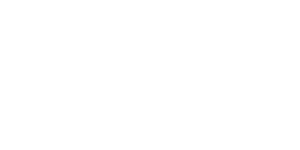

Saving figures/final/opticalthickness_vs_flux.png...
Saving figures/final/opticalthickness_vs_flux.svg...
Saving figures/final/opticalthickness_vs_flux.eps...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(1, 1, 'Pryngles 0.9.10')

In [76]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=False)

correct_order = np.array([8, 4, 0, 7, 3, 6, 2, 5, 1])
for i,teta0 in enumerate(teta0s[correct_order]):
    flux = Fs[:,i,0]
    Pflux = (Fs[:,i,1]**2+Fs[:,i,2]**2)**0.5
    P = -Fs[:,i,1]/Fs[:,i,0]
    
    axs[0].plot(tau_rings,flux,label=f"$\\theta_0 = {teta0*Consts.rad:.0f}^\circ$",linewidth=2)
    axs[1].plot(tau_rings,Pflux,linewidth=2)
    axs[2].plot(tau_rings,abs(P),linewidth=2)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylabel("Flux")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.48),
              ncol=4)
axs[0].grid()
axs[0].yaxis.set_major_locator(ticker.LogLocator(10.0,numticks=5))
axs[0].yaxis.set_minor_locator(ticker.LogLocator(10.0,subs='auto'))
axs[0].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
axs[0].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylabel("Polarized flux")
axs[1].grid()
axs[1].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
axs[1].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

axs[2].set_xscale("log")
axs[2].set_xlabel("Optical thickness")
axs[2].set_ylabel("Degree of Polarization")
axs[2].grid()
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(0.02))
axs[2].yaxis.set_minor_locator(ticker.AutoMinorLocator())
axs[2].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
axs[2].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

save_figure(fig,"opticalthickness_vs_flux", fig_dir=fig_final_dir, dpi=600, formats=['png','svg','eps'])
prymark(axs[0])

### Diagram showing configuration

Now we will generate the diagram showing the configuration of the planet around its orbit:

In [77]:
# Global configuration of the system
gamma = 60.0 # Ring inclination, 90 is edge-on, 0 is face-on 
lambr = 0.0 # Ring roll angle of the ring
iorb = 70.0 # Orbit inclination, 90 is edge-on, 0 is face-on 

# Calculate planet-centered conditions
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb, gamma, lambr)

print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 10.0 deg
	Inclination of the observer w.r.t ecliptic: 20.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg


Create the system

In [78]:
sys = pr.System()

s=sys.add(kind="Star",
          physics=dict(radius=Consts.rsun/sys.ul),
          optics=dict(limb_coeffs=[0.65]))

p=sys.add(kind="Planet", primary=s, 
          radius=Consts.rsaturn/sys.ul,
          orbit=dict(a=1, e=0.0),
          physics=dict(radius=Consts.rsaturn/sys.ul),
          optics=dict(nspangles=10000))

r=sys.add(kind="Ring", primary=p,
          physics=dict(fi=1.2, fe=2.25, i=ir),
          optics=dict(nspangles=10000))

RP=sys.ensamble_system(extension=extension,
                       fname_planet=tmp_dir + 'fou_bmsca60.0_asurf1.0.dat',
                       fname_ring=tmp_dir + 'fou_ring_0_4_0_8.dat')

Create individual snapshots of the planet around the orbit:

In [79]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,9)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP.updateSpangles()

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    RP.updateSpangles()
    RP.updateReflection()

    print(f"Saving snapshots at true anomaly: {(lamb-lamb_initial)*Consts.rad}")
    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
    ecl_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_ecl.png", dpi=500)
    obs_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_obs.png", dpi=500)
    star_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_star.png", dpi=500)
    plt.close()

Saving snapshots at true anomaly: 0.0
Saving snapshots at true anomaly: 45.0
Saving snapshots at true anomaly: 90.0
Saving snapshots at true anomaly: 135.0
Saving snapshots at true anomaly: 180.0
Saving figures/polarimetry-N_1.00-io_20.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_0.01-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.60-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.00-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_5.00-a_1.00-e_0.00-Rs_695700000.

Now we can compose the configuration image:

<IPython.core.display.Javascript object>


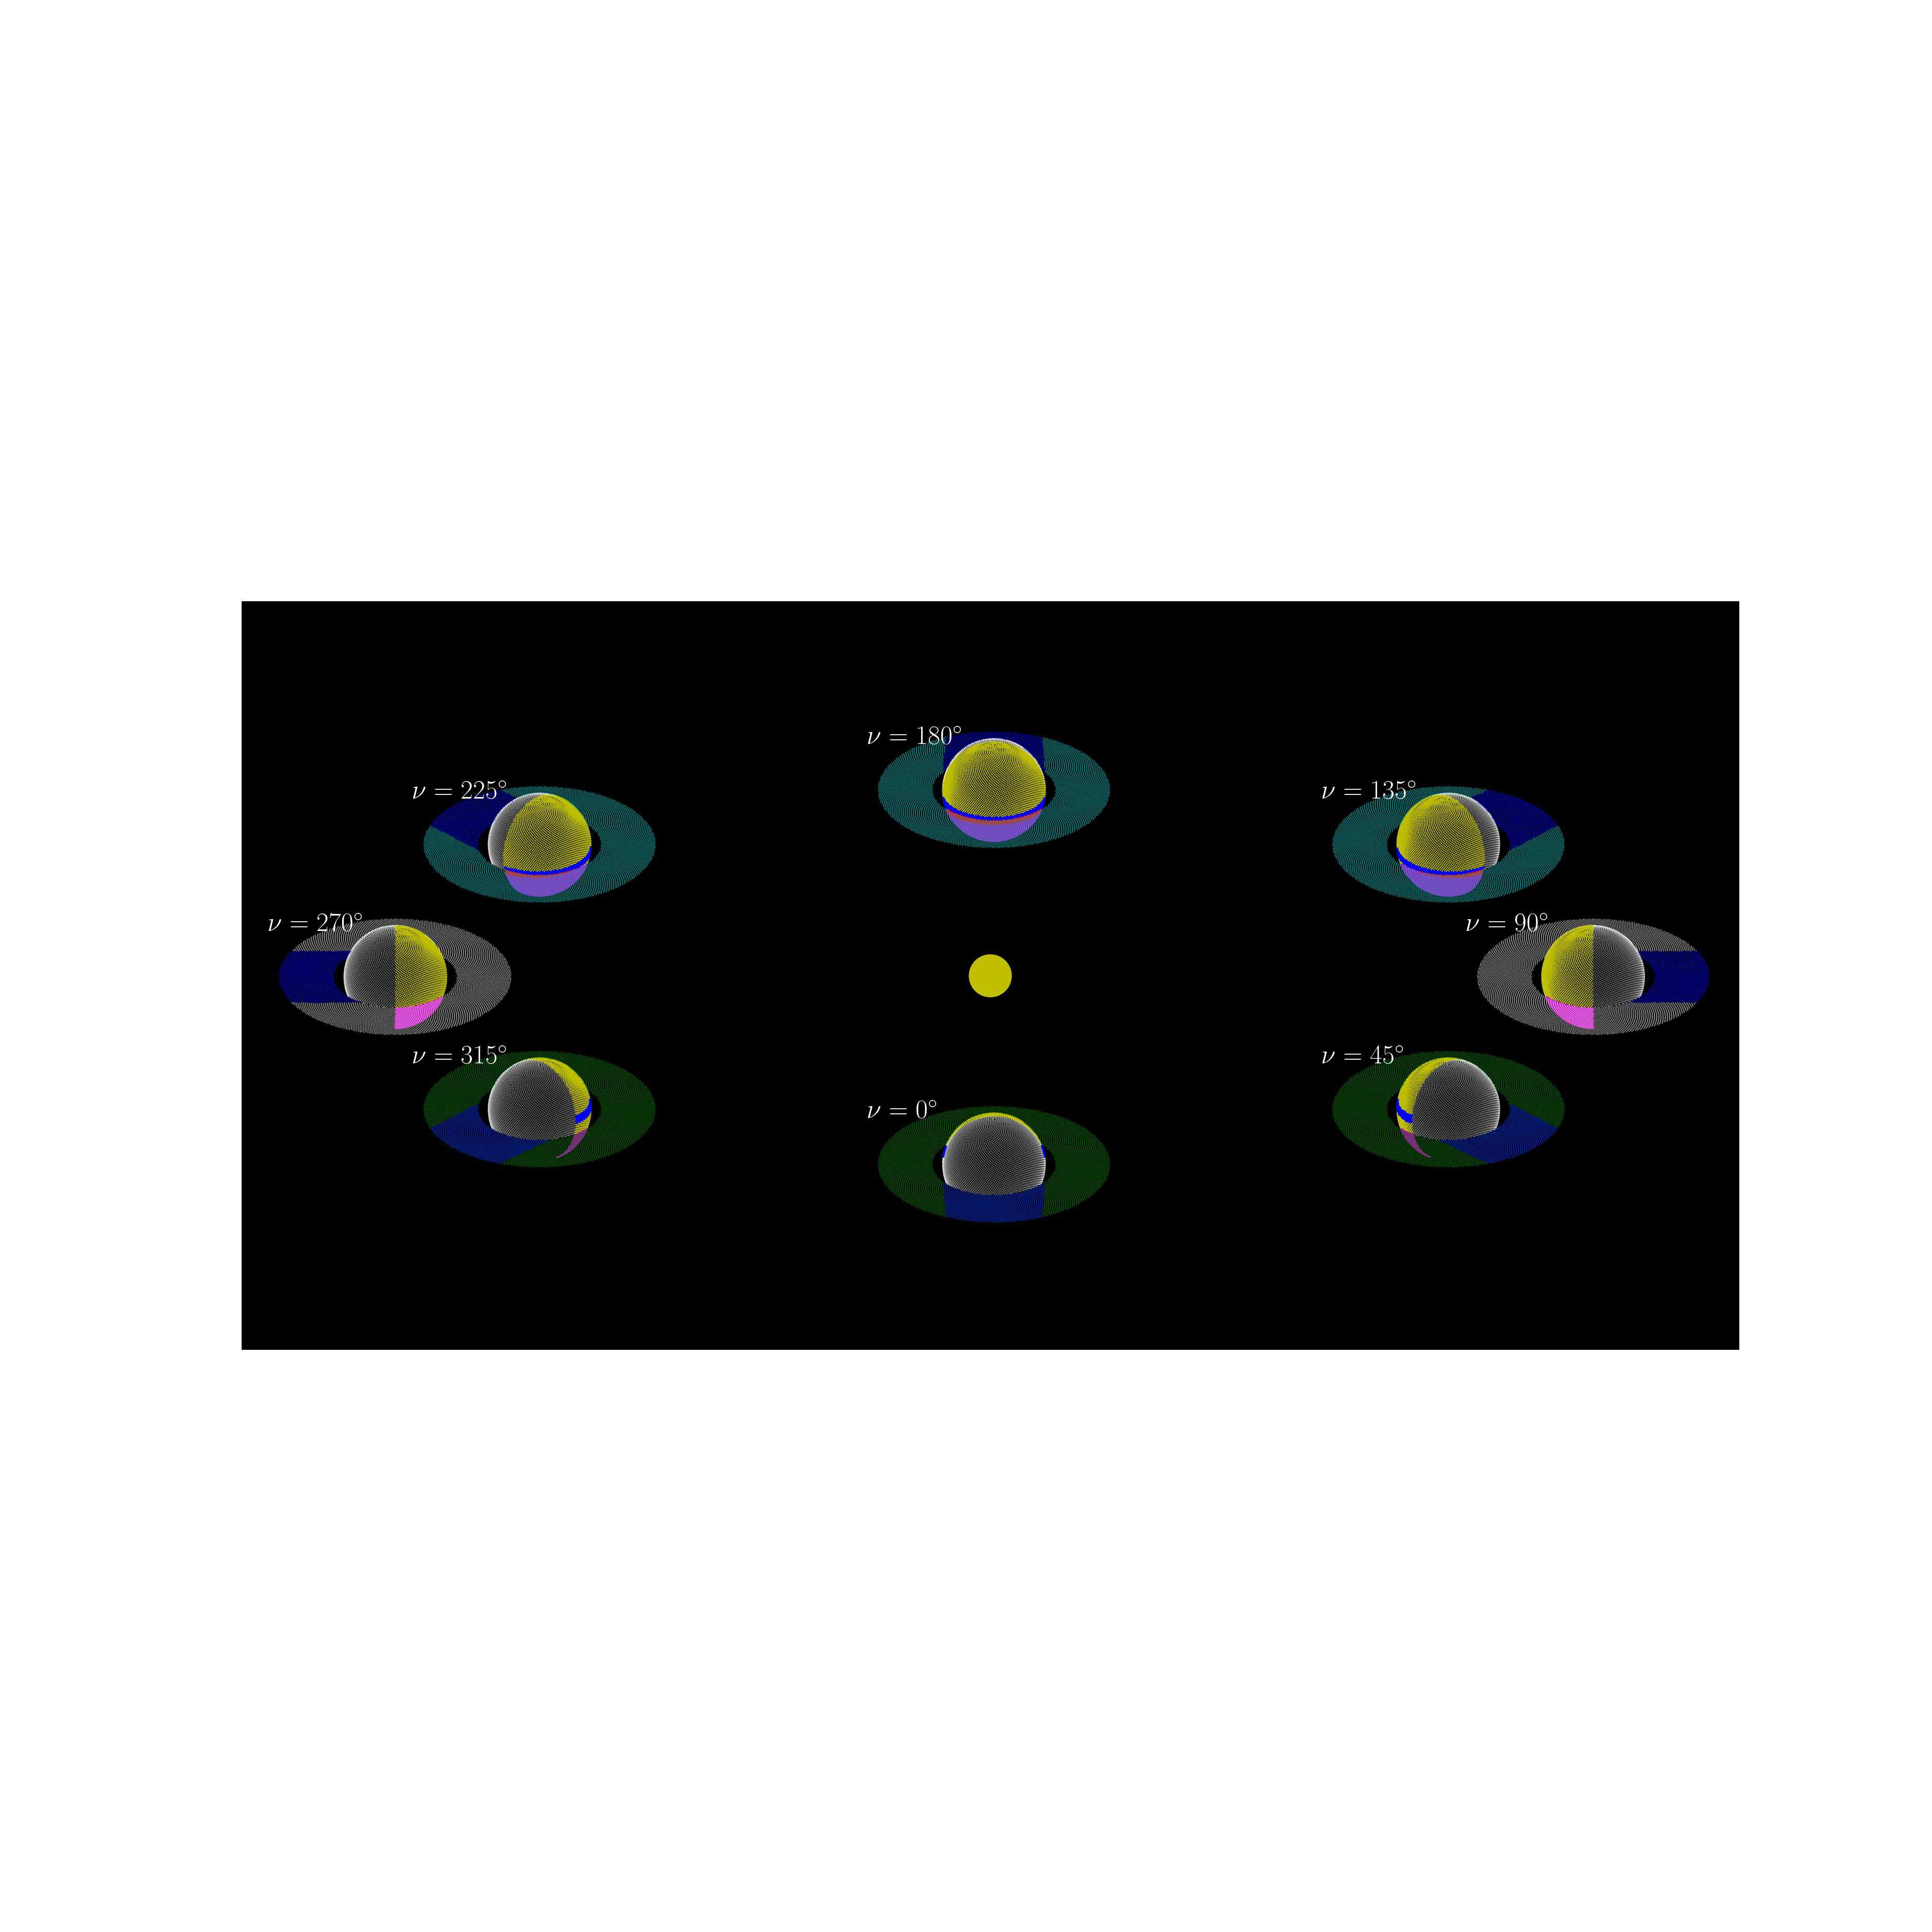

Introducing image 0 corresponging to longitude 0...
Introducing image 1 corresponging to longitude 45...
Introducing image 2 corresponging to longitude 90...
Introducing image 3 corresponging to longitude 135...
Introducing image 4 corresponging to longitude 180...
Introducing image 5 corresponging to longitude 225...
Introducing image 6 corresponging to longitude 270...
Introducing image 7 corresponging to longitude 315...


In [80]:
fsize = 5 # Use 5 for paper purposes

# Coordinates for the location of the images and labels
def loc_func(phi,a,b):
    x = a*np.cos(phi)+0.5
    y = b*np.sin(phi)+0.5
    return x,y

# Locations
lambs = np.array([0,45,90,135,180,225,270,315])
names=[]
for lamb in lambs:
    names+=[f"$\nu={lamb:d} \degree$"]

# Insert image properties
ratio = np.sin(np.pi/2 - 60*np.pi/180)
xpixels = 5000
ypixels = int(xpixels*ratio)
img = np.zeros((ypixels,xpixels))

# Axis sizes
ysize = 0.4*ratio
xsize = 0.4

# Convert to 3 channel black (color)
img = cv.merge([img,img,img])

# Location of subplot
phi = np.linspace(-np.pi/2,3/2*np.pi,9)
a = 0.5
b = 0.5*ratio
xloc,yloc = loc_func(phi,a,b)

# Offset
eqv75 = 0.75#1-np.sin(45*np.pi/180)/2
eqv25 = 0.25#np.sin(45*np.pi/180)/2

xoffset = np.array([0.5*ysize,eqv75*ysize,ysize,eqv75*ysize,0.5*ysize,
                    eqv25*ysize,0,eqv25*ysize])
yoffset = np.array([xsize,eqv25*xsize,0.5*xsize,eqv75*xsize,0,eqv75*xsize,
                    0.5*xsize,eqv25*xsize])
sub_plot_locx = xloc[:-1]-xoffset
sub_plot_locy = yloc[:-1]-xsize*0.5#yoffset

#Create figure
fig = plt.figure(figsize=(5*fsize,5*fsize))
gs = fig.add_gridspec(1)
axs = gs.subplots(sharex=False)
axs.imshow(img)
star = plt.Circle((2500, 2500*(ratio)), 70, color='y')
axs.add_patch(star)

for ii,lamb in enumerate(lambs):
    print(f"Introducing image {ii} corresponging to longitude {lamb}...")
    figure_loc = fig_dir + f"fig_at_{lamb}_obs.png"
    figure = cv.imread(figure_loc)

    subpos = [sub_plot_locx[ii],sub_plot_locy[ii],ysize,xsize]
    subax1 = add_subplot_axes(axs,subpos)

    b, g, r = cv.split(figure)
    tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
    _,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
    rgba = [r,g,b, alp]
    figure_crop = cv.merge(rgba,4)
    scale = 6/9 #5/9
    width = int(figure_crop.shape[1] * scale)
    height = int(figure_crop.shape[0] * scale)
    dim = (width,height)
    resized = cv.resize(figure_crop, dim, interpolation = cv.INTER_AREA)
    subax1.imshow(resized, interpolation='spline36', aspect='auto')
    subax1.text(0.09, 0.67, f"$\\nu={lamb}^\circ$", 
                {'fontsize': 5*fsize}, horizontalalignment='left',
                verticalalignment='center', transform=subax1.transAxes,color="w")
    subax1.set_axis_off()
    
axs.set_axis_off()

Finally we can save the image:

In [81]:
save_figure(fig, "Diff_positions_new", fig_dir=fig_final_dir, dpi=600, formats=['png','svg','eps'])

Saving figures/final/Diff_positions_new.png...
Saving figures/final/Diff_positions_new.svg...
Saving figures/final/Diff_positions_new.eps...
Saving figures/polarimetry-N_1.00-io_30.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_90.00-rl_0.00-ri_80.00-br_0.00-omr_0.80-bp_10.00-omp_0.50-rin_2.00-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_0.80-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.80-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.00-io_20.00-rl_30.00-ri_60.00-br_1.00-omr_0.30-bp_10.00-omp_0.50-rin_1.20-rou_2.25-a_1.00-e_0.00-Rs_695700000.00-Rp_60268000.00.png...
Saving figures/polarimetry-N_1.

In [82]:
# Measuring the total execution time
TEND = time.time() 
print(f"Total execution time : {(TEND-TINI)/60:.1f} minutes = {(TEND-TINI)/3600:.1f} hours")

Total execution time : 24.1 minutes = 0.4 hours


--- 
*The authors*, Last update: june 23, 2023.